In [1]:
%pylab inline
pylab.rcParams['figure.figsize'] = 12,10

Populating the interactive namespace from numpy and matplotlib


This notebook will be used to help characterize the Axon-Hillock (AH) circuit that we may end up using for the current proposed ADC (an Analog to Digital Time to Digital Converter, AD-TDC).

In [2]:
# This script will parse a CSV file taken from the Spectre Simulations and extract out the Early Voltage
import os
import sys
from scipy.optimize import leastsq
from pylab import *
import csv

# Global Functions and Variables

In [3]:
sampleTime = 20e-6

folderRoot="/home/noza/work/Braindrop/CDB/BDTests/AHOsc_test/Measurements/"

def readFile(folderRoot, fileName):
    with open(folderRoot+fileName) as fn:
        reader = csv.reader(fn)
        sampleTimes = list()
        for i, row in enumerate(reader):
            if i>1:
                sampleTimes.append(array(sorted(map(double,row[1::]))))
    return sampleTimes

def readFileUnsorted(folderRoot, fileName):
    with open(folderRoot+fileName) as fn:
        reader = csv.reader(fn)
        sampleTimes = list()
        for i, row in enumerate(reader):
            if i>1:
                sampleTimes.append(array(map(double,row[1::])))
    return sampleTimes

# This is the method to use for reading the measurements if the measurements that you want are 
# the last element of any row.
def readFile2(folderRoot, fileName):
    with open(folderRoot+fileName) as fn:
        reader = csv.reader(fn)
        freqs = list()
        for i, row in enumerate(reader):
            # Save a filtered form of the first row so that the second row can be compared to it.
            if i == 1:
                prevRow = filter(lambda x: x!='  ',row)
                #print prevRow
            if i>1:
                # Compare the length of the previous row vs the filtered current row
                # The filtering just checks that any double spaces are removed from the list
                # If the length of the rows differs, take the last value and add it to the list of freqs.
                if len(prevRow)!=len(filter(lambda x: x!='  ',row)):
                    #print len(prevRow), prevRow
                    #print len(filter(lambda x: x!='  ',row)), row
                    freqs.append(double(prevRow[-1]))
                # Save the filtered form of the current list as the previous row for the next iteration.
                prevRow = filter(lambda x: x!='  ',row)
        # Save the last row's freq as the last data point
        freqs.append(double(filter(lambda x: x!= '  ',row)[-1]))
    return list(reversed(freqs))

# This is the readFile to use if any given row is an accurate sample of the frequencies.
# In this instance, I'll take the last row to be the data point that I care about.
def readFile3(folderRoot, fileName):
    with open(folderRoot+fileName) as fn:
        reader = csv.reader(fn)
        sampleTimes = list()
        for i, row in enumerate(reader):
            if i>=1:
                sampleTimes.append(array(sorted(map(double,row[1::2]))))
    return sampleTimes[-1]

def plotFreqs(Xs, Ys, temp, pltRange, plotLog=False):
    rangeX, rangeY = pltRange[0], pltRange[1]    
    lenYs = len(Ys)
    if plotLog:
        loglog(Xs[:lenYs],Ys, '.-',label=str(temp)+"C")
    else:
        plot(Xs[:lenYs],Ys, '.-',label=str(temp)+"C")
    xlabel('$I_{in}$')
    ylabel('Freq (Hz)')
    title('Ring Oscillator Frequency vs $I_{in}$')
    xlim([0,rangeX])
    ylim([0,rangeY])

def plotGen(Xs, Ys, temp, pltRange, plotType='.-', 
            plotLog=False, ttl='Default Title', xlbl='xLabel', ylbl='yLabel', color=(1,0,0,1)):
    rangeX, rangeY = pltRange[0], pltRange[1]    
    lenYs = len(Ys)
    if plotLog:
        loglog(Xs[:lenYs],Ys, plotType, label=str(temp)+"C", color=color)
    else:
        plot(Xs[:lenYs],Ys, plotType, label=str(temp)+"C", color=color)
    xlabel(xlbl)
    ylabel(ylbl)
    title(ttl)
    xlim(rangeX)
    ylim(rangeY)

In [4]:
def linfit(xdata, params):
    m, b, I0 = params
    return m/(xdata-I0) + b

def linfitErr(params, xdata, ydata):
    m, b, I0 = params
    
    return ydata - (m/(xdata-I0) + b)
    #return ydata - linfit(xdata, params)

In [5]:
def plotLinearityF(Iins, AH_Freqs, curTemp):
    subplot(2,2,3)
    plotGen(Iins,AH_Freqs, curTemp, [[0,max(Iins)], [0,max(AH_Freqs)]],
    #plotGen(invIins,delayInv_Ts, curTemp, [[0,10],[0,10]],
            plotType = '.',
            ttl='Ring Oscillator Freq',
            xlbl='$\\frac{1}{I_{in}} (\\frac{1}{A})$',
            ylbl='$F(Hz)$')
    
    subplot(2,2,4)
    derivFs = diff(AH_Freqs)/diff(Iins)
    plotGen(Iins[1:], derivFs, curTemp, [[0,max(Iins[1:])],[min(derivFs),max(derivFs)]],
            plotType='-',
            ttl='Derivative of Ring Oscillator Freq',
            xlbl='$I_{in} (A)$',
            ylbl='$\\frac{dF}{dI_{in}}$')
    
def plotLinearityT(curinvIins, curAH_Ts, curTemp, x_th, Ts_th, xMax, yMax, dxMax, dyMin, dyMax,
                   xLbl='$\\frac{1}{I_{in}} (\\frac{1}{nA})$',yLbl='$T(\mu s)$',):
    # Determine Color Value
    curTempScale = float(curTemp)/50
    col = (curTempScale,0,1-curTempScale,1)
    
    subplot(2,2,1)
    # Plot on a linear scale
    plotGen(curinvIins, curAH_Ts, curTemp, [[0,xMax], [0,yMax]],
            plotType = '.',
            ttl='Ring Oscillator Period',
            xlbl=xLbl,
            ylbl=yLbl,
            color=col)
    
    # Plot the linear fit
    plot(1./x_th, Ts_th, '-',color=col)
    
    subplot(2,2,2)
    # Plot the derivative
    derivTs = diff(curAH_Ts)/diff(curinvIins)
    #plotGen(curinvIins[1:], derivTs, curTemp, [[0,max(curinvIins[1:])],[min(derivTs),max(derivTs)]],
    plotGen(curinvIins[1:], derivTs, curTemp, [[0,dxMax],[dyMin,dyMax]],
            plotType='-',
            ttl='Derivative of Ring Oscillator Period',
            xlbl=xLbl,
            ylbl='$\\frac{dT}{d\\frac{1}{I_{in}}}$',
            color=col)

def plotLinearity(fileName, Lims=None):
    #AH_Freqs = array(readFile2(folderRoot, fileName))
    AH_Freqs = array(readFile3(folderRoot, fileName))
    AH_Ts = (1./AH_Freqs)*1e6
    #allTs.append(AH_Ts)
    #print invIins
    if Lims == None:
        globalLims[0] = xLim = max(globalLims[0], max(invIins))
        globalLims[1] = yLim = max(globalLims[1], max(AH_Ts))
        derivLims[0] = dxMax = max(derivLims[0], max(invIins[1:]))
        derivLims[1] = dyMin = min(derivLims[1], min(diff(AH_Ts)/diff(invIins)))
        derivLims[2] = dyMax = max(derivLims[2], max(diff(AH_Ts)/diff(invIins)))
    else:
        xLim, yLim = Lims

    x_th = linspace(min(scaledIins),max(scaledIins), num=100)
    sol = leastsq(linfitErr, (1.1, 0.001, 0), (scaledIins, AH_Ts))
    Ts_th = linfit(x_th, sol[0])

    plotLinearityT(invIins, AH_Ts, curTemp, x_th, Ts_th, xLim, yLim, dxMax, dyMin, dyMax)
    #plotLinearityF(Iins, AH_Freqs, curTemp)
    return AH_Ts, sol[0]



def plotLinearitySmallIins(fileName, Lims=None, dLims=None):
    #AH_Freqs = array(readFile2(folderRoot, fileName))
    AH_Freqs = array(readFile3(folderRoot, fileName))
    AH_Ts = (1./AH_Freqs)*1e3
    #allTs.append(AH_Ts)
    #print invSmallIins
    if Lims == None:
        globalLims[0] = xLim = max(globalLims[0], max(invSmallIins))
        globalLims[1] = yLim = max(globalLims[1], max(AH_Ts))
        derivLims[0] = dxMax = max(derivLims[0], max(invSmallIins[1:]))
        derivLims[1] = dyMin = min(derivLims[1], min(diff(AH_Ts)/diff(invSmallIins)))
        derivLims[2] = dyMax = max(derivLims[2], max(diff(AH_Ts)/diff(invSmallIins)))
    else:
        xLim, yLim = Lims
        dxLim, dyLim = dLims

    x_th = linspace(min(scaledSmallIins),max(scaledSmallIins), num=10000)
    sol = leastsq(linfitErr, (1.1, 0.001, 0), (scaledSmallIins, AH_Ts))
    Ts_th = linfit(x_th, sol[0])

    plotLinearityT(invSmallIins, AH_Ts, curTemp, x_th, Ts_th,
                   xLim, yLim, dxMax, dyMin, dyMax, '$\\frac{1}{I_{in}} (\\frac{1}{pA})$','$T(ms)$')
    #plotLinearityF(SmallIins, AH_Freqs, curTemp)
    return AH_Ts, sol[0]

In [7]:
# Calculate the Relative RMSE of data compared to the fit
def calcRRMSE(scaled_Iins, Ts, Params):
    thTs = linfit(scaled_Iins, Params)
    #print (Ts - thTs)
    se = (Ts - thTs)**2
    resSampVar = sum(se)/(len(se)-1)
    #print 'Residual Variance: {}'.format(resSampVar)
    rms = sqrt(mean(thTs**2))
    rrmse = sqrt(resSampVar/rms)
    #print 'Relative RMSE: {:%}'.format(rrmse)
    return rrmse

In [48]:
# This function will print out the percentage of the overall period that is attributed to the inverter delay.
def percPeriodbyDelay(TsAsFuncOfIin, curIins, avgLoopDelay, curTemps):
    print 'Percent of overall period taken by delay from feedback buffer delay'
    print '{:>5s}\t\t'.format("Iins") + "%s"%'\t'.join(curTemps)
    for i, curTs in enumerate(TsAsFuncOfIin):
        #print mean(curTs), max(curTs), min(curTs), std(curTs), var(curTs)
        Iins_fA = curIins[i]/10**-15
        percDelay = avgLoopDelay*1e3/curTs
        foo = list()
        for i, curPDelay in enumerate(percDelay):
            #print '\t{:^6.3%}'.format(percDelay[i])
            foo.append('\t{:^6.3%}'.format(percDelay[i]))
        #print foo
        print '{:>5.0f} fA'.format(Iins_fA) + ''.join(foo)
# Calculate the percentage variance that results from the variation in temperature.
def percVariancebyTemp(TsAsFuncofIin,curIins):
    print
    print '{:>5s}\t\t{:^12s}'.format("Iins", "Percent Error")
    for i, curTs in enumerate(TsAsFuncOfIin):
        #print mean(curTs), max(curTs), min(curTs), std(curTs), var(curTs)
        Iins_pA = SmallIins[i]/10**-12
        re = (max(curTs)-min(curTs))/mean(curTs)
        print '{:>6.3f} pA\t{:^12.3%}'.format(Iins_pA, re)

# Axon Hillock (AH) Analysis


## Linearity Analysis

This section will have all of the linearity analysis that I will perform for the AH circuit.  The goal will be to see if we can figure out if this circuit is truly nonlinear like we want, and if not, where the nonlinearity is coming from.

This just gets the value of the swept parameters, $I_{in}$ and Temp (if the temperature was swept)

In [6]:
paramFile = open(folderRoot+"SweptParams.csv")
for i, row in enumerate(csv.reader(paramFile)):
    if i == 0:
        temps = array(row[1:])
        print "Temps: ", temps
    elif i==1:
        Iins = array(double(row[1:]))
        print "Iins: ", Iins
    else:
        print "Too many rows"
scaledIins = Iins*1e9
print scaledIins
invIins = 1./scaledIins
print invIins

Temps:  ['0' '5' '10' '15' '20' '25' '30' '35' '40' '45' '50']
Iins:  [  1.00000000e-11   2.15443469e-11   4.64158883e-11   1.00000000e-10
   2.15443469e-10   4.64158883e-10   1.00000000e-09   2.15443469e-09
   4.64158883e-09   1.00000000e-08]
[  0.01         0.02154435   0.04641589   0.1          0.21544347
   0.46415888   1.           2.15443469   4.64158883  10.        ]
[ 100.           46.41588834   21.5443469    10.            4.64158883
    2.15443469    1.            0.46415888    0.21544347    0.1       ]


The circuit below is my first stab at an AH implementation.  This implementation uses only Thick Oxide (eg) transistors in the circuit, including for the MOSCap.  The configuration used for this includes a starved inverter that feeds into the capacitance divider, which then feeds into two consecutive inverters (to act as a gain amplifier/buffer).  The output of this buffer is then fed back into one of the terminals of C2 (the top capacitor of the capacitance divider).

The be more specific about the description, the starved inverter has 4 transistors in series (the drain of one transistor connects to the drain of the next transistor).  The top transistor's -- a PFET sized as 2 transistors, 180n x 150n, 3L -- gate is controlled by $V_{gp}$, which is set to the value corresponding to $I_{in}$ through a PFET transistor.  The next two transistors, a PFET on top of an NFET, form a generic inverter (same width and length as the transistors above, but only 1L) whose gate is controlled by the "out" node.  The purpose of this inverter is to switch between the top current source and the bottom current source.  The bottom current source is implemented by an NFET transistor -- sized as 2 transistors wide, 160n x 150n, 3L -- with its gate connected $V_{gn}$.  $V_{gn}$ is set by a current mirror through and NFET.  In the case of both $V_{gp}$ and $V_{gn}$, the gate voltages are actually buffered using a vcvs with a gain of 1, so that we can try to best eliminate other transient effects from our current understanding.

All subsequent designs/analysis branch from this basic design in order to best find out where the nonlinearity is coming from, b/c as we can see below, this basic design is still nonlinear.

[  5.65319629e-01   1.18416036e-01  -2.11214771e-04]


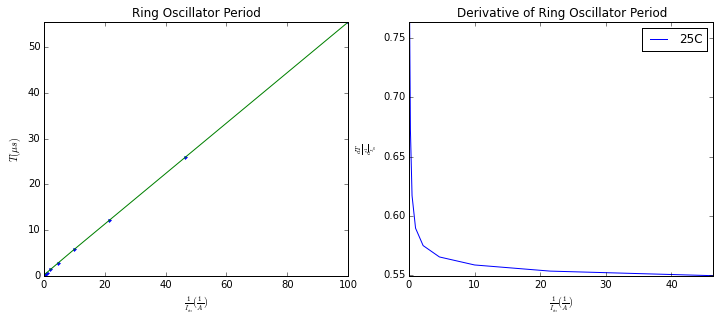

In [48]:
allTs = list(list())

for curTemp in [25]:#temps:
    fileName = "AH_InvEg_FreqMeas_Temp"+str(curTemp)+"C.csv"
    plotLinearity(fileName)

    legend(loc='best')

### No Buffer
This first deviation is the analysis if we take the buffers out of the picture and have the throttling transistors (the top (PFET) and bottom (NFET) transistors) being controlled directly by the current mirror.  Otherwise, everything in this setup is same as before.

[  4.77683369e-01   1.20327169e-01  -2.28120678e-04]


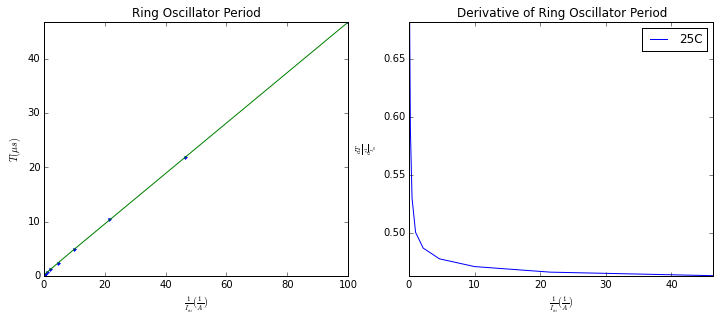

In [65]:
allTs = list(list())

for curTemp in [25]:#temps:
    fileName = "AH_InvEg_FreqMeas_Temp"+str(curTemp)+"C_NoBuffer.csv"
    plotLinearity(fileName)
legend(loc='best')

### Sizing the Capacitors
In this section, I try to wean out whether or not the size of the capacitors affects the linearity.  I thought they might be affecting the linearity because they might have been operating in a region where the the CV curve isn't flat, and therefore, the capacitance value was changing.  As such, I thought if I could get the $\Delta V$ value of $V_{cap}$ to swing by less, then the capacitor would operate in a similar regime always and would therefore, be more likely to be linear.  $\Delta V$ should swing by an amount equal to $\frac{C_2}{C_1+C_2}$, and therefore, my first idea was to increase $C_1$'s capacitance.

It should be noted that I also tried to characterize the capacitors a little bit, and following my characterization as well as Ben's CV curves, I chose to use an NFET that's minimum sized, with it's Source and Drain nodes connected to $V_{cap}$.  When the S and D nodes are connected to the $V_{cap}$ node, it was shown that this helped with the linearity of the capacitor the most, and that is why this configuration was chosen.  Assuming Ben's analysis and my analysis are similar, I'm using the working approximation of $C_1$ and $C_2$ to be $\approx150aA$.

It should also be noted that for all of these cap-sizing analyses, there was no buffer between the current mirror and the throttling gates.  This was because a quick analysis showed that they didn't change the behavior by much.  My intuition for why this is the case is because there aren't enough mirrored gates which have their own capacitance to weigh down the line to cause any unexpected behavior.

####  $C_1$ 460n X 450n 1L 
The easiest way to increase capacitance is to increase the area of the "plates" and as such, I made $C_1$ roughly 3 times wider and 3 times longer.  As you can see it doesn't really change the linearity of the plot.

[  4.79256018e-01   1.29532442e-01  -2.40480673e-04]


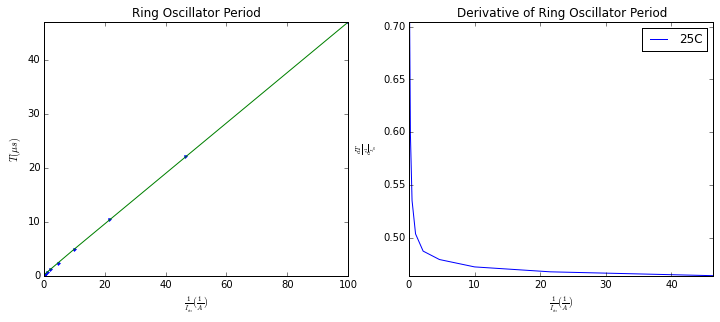

In [66]:
allTs = list(list())

for curTemp in [25]:#temps:
    fileName = "AH_InvEg_FreqMeas_Temp"+str(curTemp)+"C_NoBuffer_C1_460nx450n1L.csv"
    plotLinearity(fileName)
legend(loc='best')

####  $C_1$ 460n X 450n 3L 
The next thing I tried was to make the transistor even longer.

[  4.79481350e-01   1.29620503e-01  -2.44500782e-04]


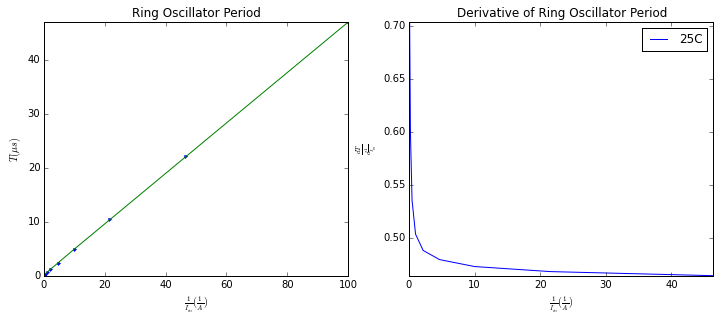

In [67]:
allTs = list(list())

for curTemp in [25]:#temps:
    fileName = "AH_InvEg_FreqMeas_Temp"+str(curTemp)+"C_NoBuffer_C1_460nx450n3L.csv"
    plotLinearity(fileName)
legend(loc='best')

####  $C_1$ 160n X 150n 3L 
Just to check what is going on, I reverted back to the original dimensions of the transistors, but kept the 3 transistors-in-series-design for the capacitance.  I didn't expect this circuit to be linear, and sure enough it wasn't.

[  4.78157270e-01   1.19265569e-01  -2.38668777e-04]


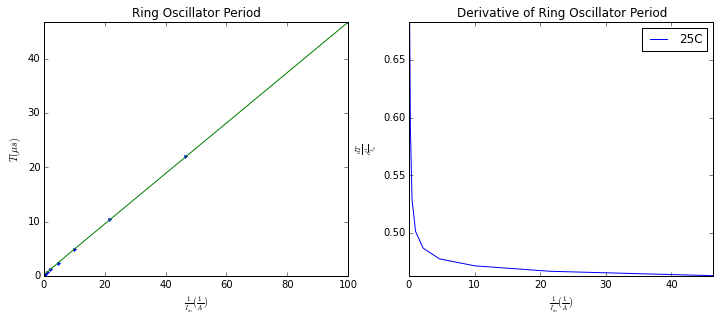

In [52]:
allTs = list(list())

for curTemp in [25]:#temps:
    fileName = "AH_InvEg_FreqMeas_Temp"+str(curTemp)+"C_NoBuffer_C1_160nx150n3L.csv"
    plotLinearity(fileName)
legend(loc='best')

####  $C_2$ 460n X 450n 1L 
Just to double check my intuition, I wanted to test what would happen if I sized $C_2$ with a larger capacitance.  The first thing that it should have done is make the circuit slower, which it does, as evidenced from the overall length of the period.  It should make the circuit slower because now $\Delta V$ should jump by a larger proportion of $V_{dd}$, which means the capacitance has a farther way to travel to get back to the transition point of the inverter.

The second thing my intuition said it should not do is change the linearity.  Sure enough, the circuit is still nonlinear by roughly the same degree as the previous implementations.

[  7.59935950e-01   1.43551166e-01  -2.07416919e-04]


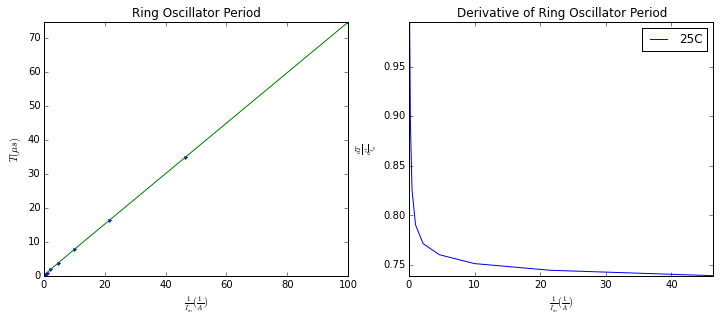

In [54]:
allTs = list(list())

for curTemp in [25]:#temps:
    fileName = "AH_InvEg_FreqMeas_Temp"+str(curTemp)+"C_NoBuffer_C2_460nx450n1L.csv"
    plotLinearity(fileName)
legend(loc='best')

####  $C_2$ 460n X 450n 3L 
Just to cover my bases, I tried this final configuration.  Interestingly, this was the first analysis where the slope wasn't monotonic.  I'm not sure why this is the case, but decided after this that I should try to better understand where the nonlinearity is coming from by using ideal elements instead of transistors which have their own underlying behaviors complicating my understand of what is happening.

[  8.31310299e-01   8.65510529e-02   3.64851906e-04]


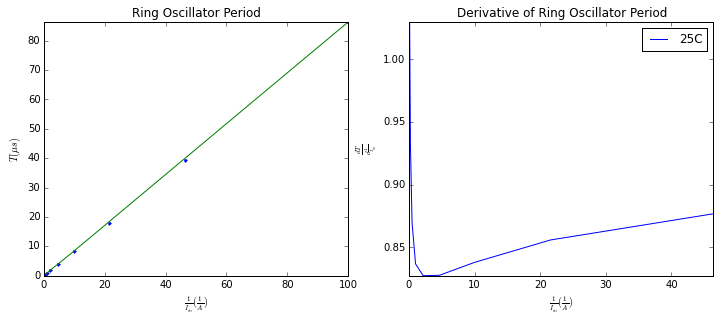

In [56]:
allTs = list(list())

for curTemp in [25]:#temps:
    fileName = "AH_InvEg_FreqMeas_Temp"+str(curTemp)+"C_NoBuffer_C2_460nx450n3L.csv"
    plotLinearity(fileName)
legend(loc='best')

###  Ideal Caps for $C_1$ and $C_2$ 
In this section, I make the assumption that the capacitors are behaving linearly because my cap sizing experiments didn't show any greatly different effects between the many configurations.  To test this assumption, I use ideal capacitors in the simulation and then try to vet out what what actually causes any of the nonlinearity.

This first measurement shows two things.  First it shows that using an approximate value of 150aA, is on the same order as the previous measurements, because the circuit has a similar period over the same range of input currents.  The second thing it shows is that even using ideal capacitors, the circuit is still behaving nonlinearly.  This confirms my hypothesis that some other part of the circuit is causing the nonlinearity.

[  5.63447587e-01   1.24121549e-01  -2.22920361e-04]


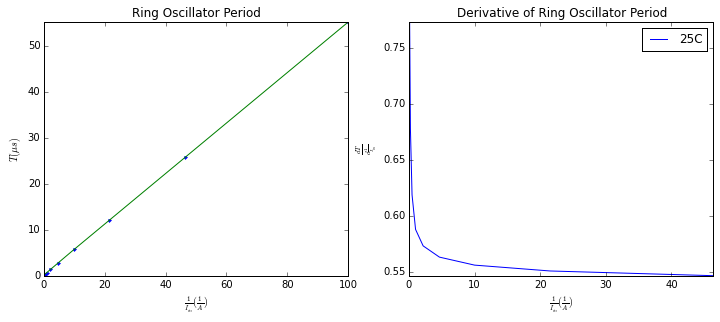

In [57]:
allTs = list(list())

for curTemp in [25]:#temps:
    fileName = "AH_InvEg_FreqMeas_Temp"+str(curTemp)+"C_NoBuffer_IdealCaps_150a.csv"
    plotLinearity(fileName)
legend(loc='best')

#### Switch on the Rails

My first theory regarding where the nonlinearity might be coming from is that I am using two transistors to try and control which current source is charging or discharging the capacitors.  In the original configuration these switching transitors were placed at the drains of my throttling transistors (or current sources).  In this test, I move the switches to the rails so that they are placed at the sources of the current sources.  I double checked that when I do this, the node between the switch and the current source goes all the way up to 1V and down to 0V, respectively, so that we can ensure that the current mirror operates properly.  To also ensure that this current mirror operates properly, I have reverted back to using a buffer on the gates of these throttling transistors.  It allows me to ensure that I am worrying about one less possible source of nonlinearity.

Sadly, this doesn't help the circuit much and it still behaves nonlinearly.

[  5.88111563e-01   1.40397589e-01  -2.66061953e-04]


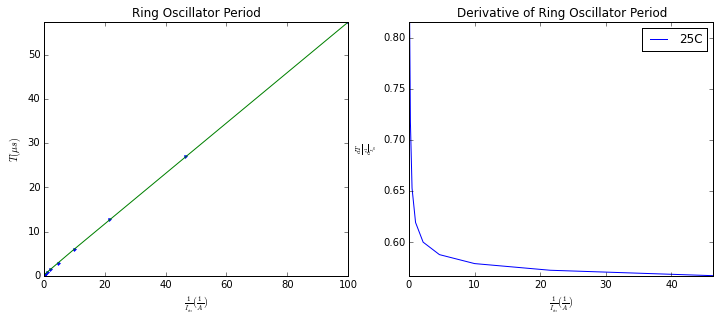

In [60]:
allTs = list(list())

for curTemp in [25]:#temps:
    fileName = "AH_InvEg_FreqMeas_Temp"+str(curTemp)+"C_Buffer_SwitchonEdges_IdealCaps_150a.csv"
    plotLinearity(fileName)
legend(loc='best')

####  Ideal Current Sources
My next guess was that using transistors for the gates might be causing some nonlinearity, and as such, I should just try ideal current sources.  This will prove whether the nonlinearity is coming from the inverters or not.  It eliminates the throttling transistors as a source of the nonlinearity for now.  This is not to say they aren't contributing to the nonlinearity, but if the circuit is still nonlinear after this, then it must be coming from the inverters because every other part of this circuit is using an ideal component now.

Sure enough this circuit is nonlinear and as such, the nonlinearity must be coming from the two inverters that are used to form a buffer.

[  2.90781136e-01   8.44949409e-02  -2.11868711e-04]


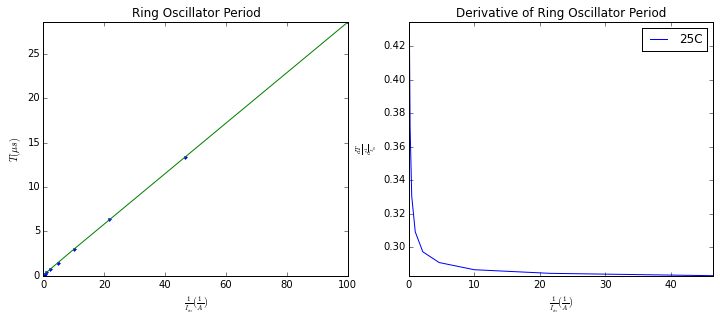

In [62]:
allTs = list(list())

for curTemp in [25]:#temps:
    fileName = "AH_InvEg_FreqMeas_Temp"+str(curTemp)+"C_IdealCS_IdealCaps_150a.csv"
    plotLinearity(fileName)
legend(loc='best')

####  Ideal AH circuit
Because we think the nonlinearity is coming from the inverters, we want to see that an ideal circuit behaves linearly by using all ideal components.  This establishes that the circuit should theoretically work linearly.

Happily enough, this circuit operates very linearly, even in the frequency domain! :-D

Because this is the equivalent of having a "baseline" measurement, I also plotted all of the temperatures to show how the ideal AH circuit should behave with variation in temperature.

0 [  2.99457808e-01  -9.77332121e-05   1.08780842e-06]
5 [  2.99444466e-01  -1.73280624e-05   1.72384888e-06]
10 [  2.99525753e-01  -2.61042389e-04  -1.53259257e-06]
15 [  2.99463948e-01  -6.23962205e-05   2.60486062e-07]
20 [  2.99384926e-01   1.70314062e-04   2.98429938e-06]
25 [  2.99452672e-01  -4.79948300e-05  -4.06799353e-07]
30 [  2.99453440e-01  -2.85422749e-05   7.62918100e-07]
35 [  2.99417086e-01   1.30723298e-04   1.86086851e-06]
40 [  2.99482086e-01  -3.48348725e-05  -1.31942871e-06]
45 [  2.99527455e-01  -1.32177885e-04  -4.15301953e-06]
50 [  2.99464932e-01  -4.19398675e-05   1.05520903e-07]


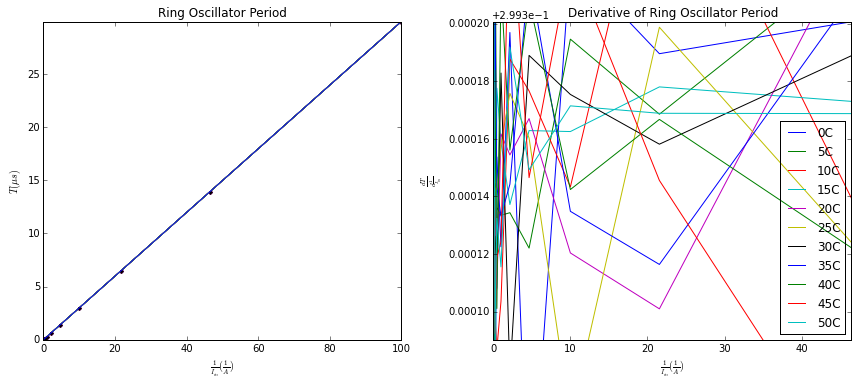

In [108]:
allTs = list(list())

for curTemp in temps:
    fileName = "IdealAH_TempSweep/AH_InvEg_FreqMeas_Temp"+str(curTemp)+"C_IdealAH.csv"
    # Note: This run required changing the readFile function that plotLinearity uses from readFile2 to readFile3
    plotLinearity(fileName)
legend(loc='best')
tight_layout()

### Ideal Amplifier Buffer
#### Ideal capacitors $C_1$ and $C_2$ and non-ideal switched current sources
In this test, I got rid of the ideal current sources, but kept the ideal caps and the ideal buffer.  This will hopefully result in a linear plot and thereby give more evidence that the nonlinearity is coming from the inverters that I use to create the buffer.

Assuming this is linear, then my next test will be to take the ideal caps and make them MOSCaps again (with minimum sizing for thick oxide.

As can be seen below, the starved inverter that acts as a switch source for the inverters introduces some nonlinearity, but the overall nonlinearity is still very small (a ratio of 1.04 (.855/.820) from one end of the range to the other).  This is promising and helps us further incriminate the amplifier buffer as the main source of the nonlinearity.

[  8.31837939e-01   2.65722853e-02  -1.22865719e-04]


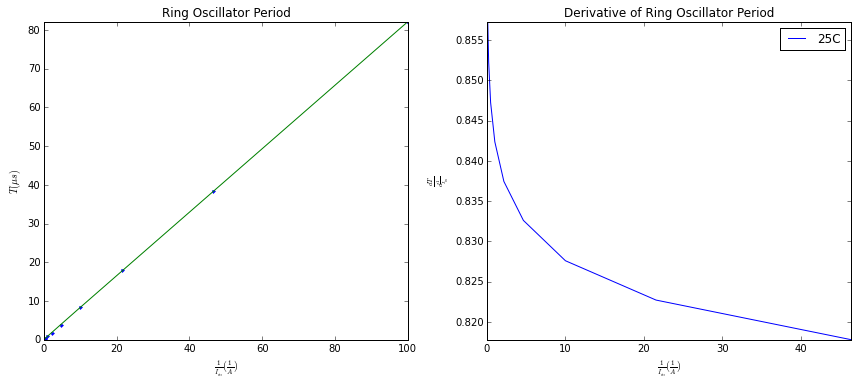

In [88]:
allTs = list(list())

for curTemp in [25]:#temps:
    fileName = "AH_InvEg_FreqMeas_Temp"+str(curTemp)+"C_IdealAmplifierBuffer_IdealCaps.csv"
    # Note: This run required changing the readFile function that plotLinearity uses from readFile2 to readFile3
    plotLinearity(fileName)
legend(loc='best')
tight_layout()

#### Non-ideal capacitors and non-ideal switched current sources
The result below shows that although having non-ideal capacitors and non-ideal current sources still accounts for some of the nonlinearities, the bulk of the nonlinearity is because of the two inverters used to create a buffer in the axon-hillock circuit.  This is great because it shows us that we really need to focus on making the buffer nice and linear and then this circuit will work much better.

[  7.44801215e-01   2.41643517e-02  -1.26536515e-04]


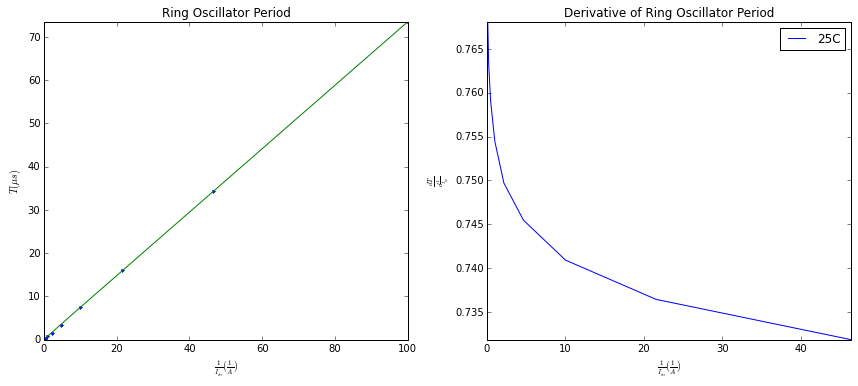

In [90]:
allTs = list(list())

for curTemp in [25]:#temps:
    fileName = "AH_InvEg_FreqMeas_Temp"+str(curTemp)+"C_IdealAmplifierBuffer.csv"
    # Note: This run required changing the readFile function that plotLinearity uses from readFile2 to readFile3
    plotLinearity(fileName)
legend(loc='best')
tight_layout()

### Inverter Variations
In this section, I try to play with variations and alternatives to using two thick oxide transistors for the inverters that make up the amplifier buffer in an AH circuit.

#### Thick Oxide FETs
As a baseline, I want to run the configuration using all non-ideal elements to implement the axon-hillock circuit.  This is the original configuration that I first used except for a minor change in the location of the switches.  The switches to the current sources in this configuration are now placed on the sources, as opposed to the original configuration, where they were placed on the drains.  _Time permitting, I should analyze which of these configurations is better and why_

As can be seen below, this still behaves non-linearly with a "linearity ratio" of ~1.5.

[  4.90340649e-01   1.43400786e-01  -3.13909946e-04]


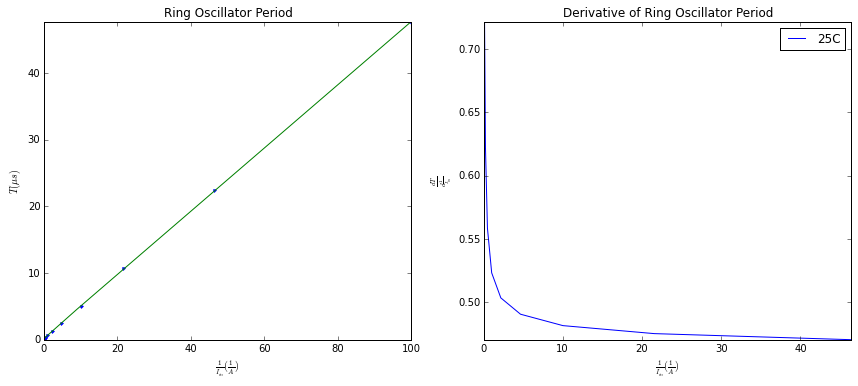

In [95]:
allTs = list(list())

for curTemp in [25]:#temps:
    fileName = "AH_InvEg_FreqMeas_Temp"+str(curTemp)+"C_Buffer_ThickFETInverters_SwitchonSources.csv"
    # Note: This run required changing the readFile function that plotLinearity uses from readFile2 to readFile3
    plotLinearity(fileName)
legend(loc='best')
tight_layout()

#### Thin Oxide FETs
The first test I wanted to double check was the usage of ThinFETs instead of thick oxide transistors.  I think this will help with the linearity because the switching will happen faster, but I don't think this will solve the problem, because I think inherently the problem is associated with the input changing at different rates for different currents.

25 [  5.07616984e-01   2.49589087e-02  -2.84625740e-04]


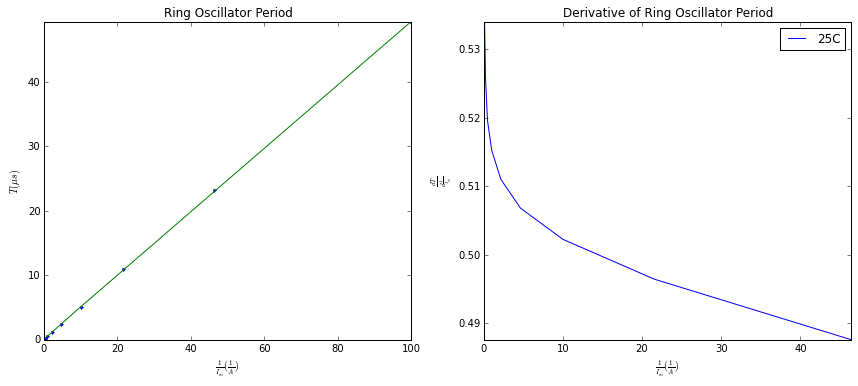

In [111]:
allTs = list(list())

for curTemp in [25]:#temps:
    fileName = "AH_InvEg_FreqMeas_Temp"+str(curTemp)+"C_Buffer_ThinFETInverters_SwitchonSources.csv"
    # Note: This run required changing the readFile function that plotLinearity uses from readFile2 to readFile3
    plotLinearity(fileName)
legend(loc='best')
tight_layout()

#### No buffer
Just to ensure that buffering isn't affecting much, I did a quick sweep with no buffers for the $V_{gn}$ and $V_{gp}$ lines.  The results show that no having the buffers slows down the circuit, but only trivially affects the linearity of the plot.

[  5.63707212e-01   2.75794148e-02  -2.90666936e-04]


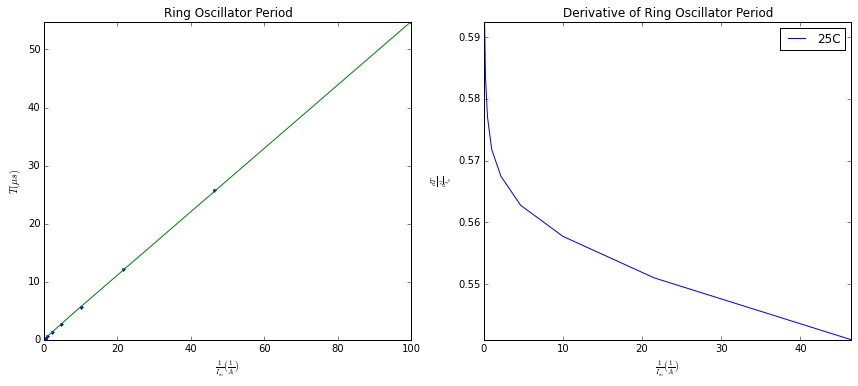

In [96]:
allTs = list(list())

for curTemp in [25]:#temps:
    fileName = "AH_InvEg_FreqMeas_Temp"+str(curTemp)+"C_NoBuffer_ThinFETInverters_SwitchonSources.csv"
    # Note: This run required changing the readFile function that plotLinearity uses from readFile2 to readFile3
    plotLinearity(fileName)
legend(loc='best')
tight_layout()

#### Moving the switches to be on the drains again
This test double checks how the circuit operates if we move the switches back to the inside of the throttling transistors.  My intuition currently says that this shouldn't affect the linearity by much and that the circuit will operate essentially the same.

Interestingly, this does affect the linearity and it actually hurts it.  I'm not exactly sure why this is the case, but when I look at the output waveforms, I can clearly see that, with the switches connected to $V_{cap}$ configuration, otherwise known as switch-on-drains, the voltage trace for $V_{cap}$ is a curve and not a nice linear descent.  In the other case it definitely looks more linear.  I think the reason for this is because, in the switch-on-drains scenario, the switching causes an immediate, high-current, rush of current into the cap.  In the other case, you get a throttled amount of current, so it allows the cap to react slowly.  Another way of saying this is that, in one case (switch-on-drains) the nets between the throttle and switches are already "pre-charged" and in the other case, those nets have to change with the cap.  I think the pre-charged situation causes nonlinearities because the node that's pre-charged essentially dips from one voltage, and then tries to go back to that voltage, meaning it's fighting the tendency of the cap, while in the other circuit, a fixed amount of charge is trying to sway back and forth.

[ 0.43588229  0.05999182 -0.00044396]


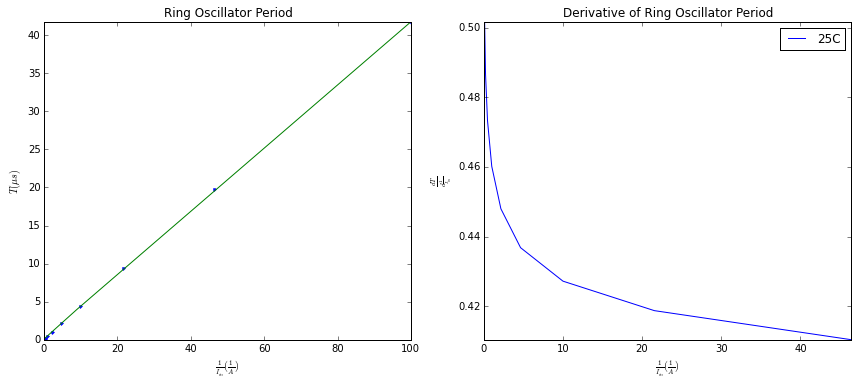

In [97]:
allTs = list(list())

for curTemp in [25]:#temps:
    fileName = "AH_InvEg_FreqMeas_Temp"+str(curTemp)+"C_NoBuffer_ThinFETInverters_SwitchonDrains.csv"
    # Note: This run required changing the readFile function that plotLinearity uses from readFile2 to readFile3
    plotLinearity(fileName)
legend(loc='best')
tight_layout()

#### Wide-range amplifier instead of two inverters
In this test, I substitute the two inverters for a wide-range amplifier.  To be more accurate, I actually took one wide-range amplifier and because it's an inverting amplifier, I piped it's output into an inverter.

_Note: I tried using a non-inverting amplifier but it's output behaved really weirdly and so I went back to using the inverting amplifier._

_Note 2: This circuit went back to using Switches on the Sources, as all circuits will do from here on out, b/c it was shown in the previous setup/test that this works more linearly._

The result below shows that the wide-range amplifier also behaves very linearly, with results similar to the thin FET configuration.  It does behave slightly more slowly than the the Thin FET and uses more transistors, so I think I will be going back to using the ThinFET design.

[  6.07157697e-01   3.07865597e-02  -2.51532217e-04]


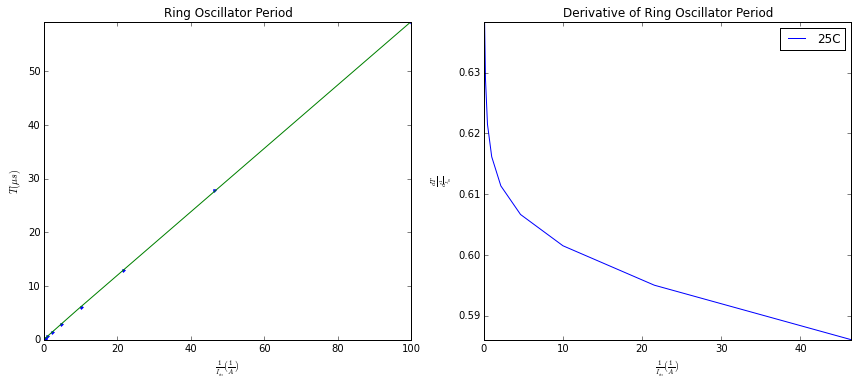

In [99]:
allTs = list(list())

for curTemp in [25]:#temps:
    fileName = "AH_InvEg_FreqMeas_Temp"+str(curTemp)+"C_NoBuffer_WideRangeAmp_SwitchonSources.csv"
    # Note: This run required changing the readFile function that plotLinearity uses from readFile2 to readFile3
    plotLinearity(fileName)
legend(loc='best')
tight_layout()

#### Switched sources
This test uses two inverters for the buffer stage, and has the switches connected to the sources of the throttling transistors.  It also doesn't uses a buffer for the $V_{gn}$ or $V_{gp}$ lines.  As such, the configuration is the same as in the "No buffer" section, three sections above this one, except for one very tiny difference.  The tiny difference is that now the switches are actually configured as an inverter, and their common output is connected to the sources, such that the circuit behaves less like a charge pump and instead just switches the voltage on the sources of the throttling transistors.  Another way to look at this is that it now looks like the delayed inverter that we analyzed in the RingOsc_Char notebook.

The result of this test appears to be slightly more linear than the previous configuration, which is promising.  I think the next test will change the source switching transistors to ThinFETs as well.  This will then change the source voltage of the throttling transistors even faster and hopefully mitigate any non-linearity that is arising from this transition.

[  4.67148564e-01   2.48051065e-02  -2.28736353e-04]


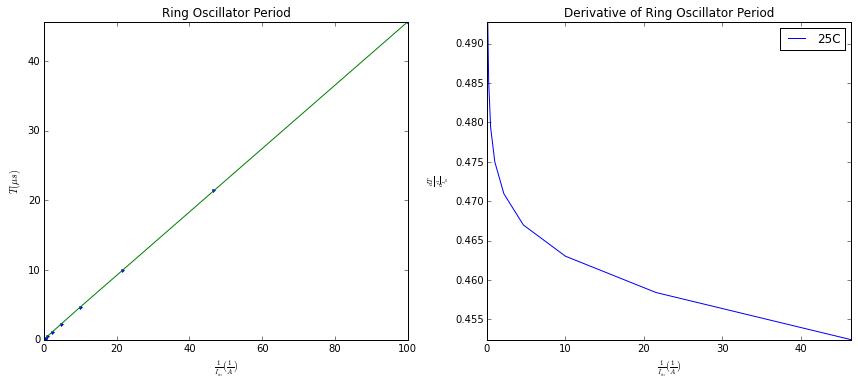

In [100]:
allTs = list(list())

for curTemp in [25]:#temps:
    fileName = "AH_InvEg_FreqMeas_Temp"+str(curTemp)+"C_NoBuffer_ThinFETInverters_SwitchedSources.csv"
    # Note: This run required changing the readFile function that plotLinearity uses from readFile2 to readFile3
    plotLinearity(fileName)
legend(loc='best')
tight_layout()

#### ThinFET Source Switches
Like I wrote about in the section above, this test uses ThinFET transistors to switch the source nodes of the current sources (throttling transistors) faster.  This will hopefully reduce the non-linearity even further.

[  4.67081608e-01   2.22010432e-02  -2.27851629e-04]


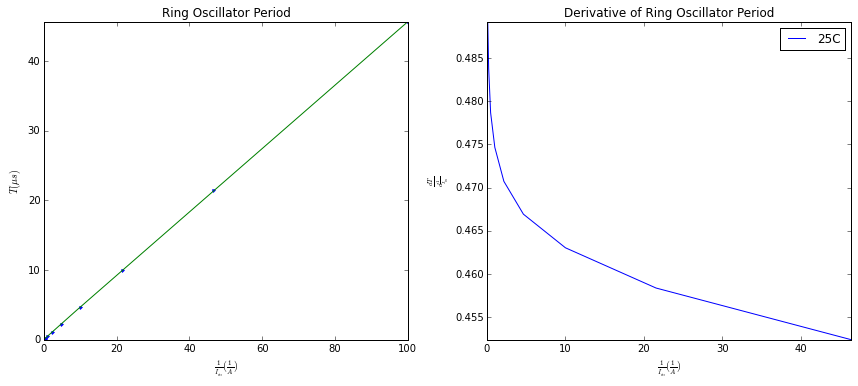

In [103]:
allTs = list(list())

for curTemp in [25]:#temps:
    fileName = "AH_InvEg_FreqMeas_Temp"+str(curTemp)+"C_NoBuffer_ThinFETInverters_SwitchedSourcesThinFET.csv"
    # Note: This run required changing the readFile function that plotLinearity uses from readFile2 to readFile3
    plotLinearity(fileName)
legend(loc='best')
tight_layout()

This sweep also includes sweeping over temperature, so that we can see how this AH circuit will operate, in it's non-ideal, but realistic, configuration.

To get a good idea of how well the fit approximates the data, we also want to calculate the RMSE of the data.  This will give us an idea of what to expect in the actual circuit when it is built.  We can see this in the "Relative RMSE" calculation, calculated using the calcRRMSE function.

Lastly, the code below also quantifies the percentage difference in the period as we sweep over temperatures for the AH circuit analyzed above.

Temp: 0	Relative RMSE: 0.398062%
Temp: 5	Relative RMSE: 0.396853%
Temp: 10	Relative RMSE: 0.393510%
Temp: 15	Relative RMSE: 0.392121%
Temp: 20	Relative RMSE: 0.393454%
Temp: 25	Relative RMSE: 0.390316%
Temp: 30	Relative RMSE: 0.389898%
Temp: 35	Relative RMSE: 0.392168%
Temp: 40	Relative RMSE: 0.386580%
Temp: 45	Relative RMSE: 0.385794%
Temp: 50	Relative RMSE: 0.385788%

 Iins		Percent Error
 0.010 nA	   1.074%   
 0.022 nA	   1.237%   
 0.046 nA	   1.292%   
 0.100 nA	   1.298%   
 0.215 nA	   1.235%   
 0.464 nA	   1.135%   
 1.000 nA	   0.921%   
 2.154 nA	   0.564%   
 4.642 nA	   0.202%   
10.000 nA	   1.088%   


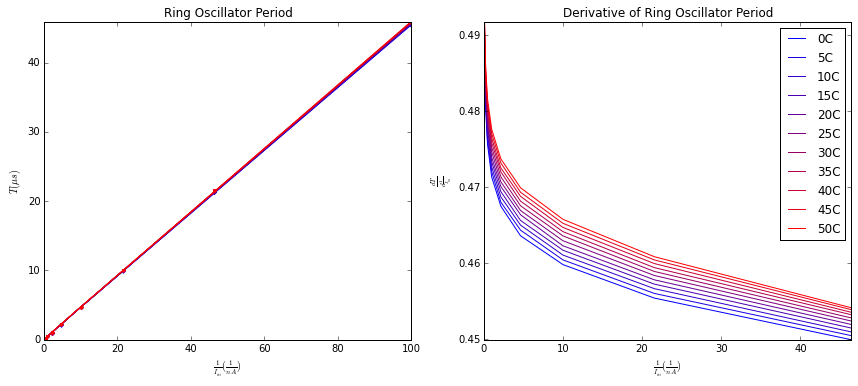

In [79]:
allTs = list(list())
globalLims = [0,0]
derivLims = [0,100000,0]

for curTemp in temps:
    fileName = "AH_TempSweep/AH_InvEg_FreqMeas_Temp"+str(curTemp)+"C_NoBuffer_ThinFETInverters_SwitchedSourcesThinFET.csv"
    # Note: This run required changing the readFile function that plotLinearity uses from readFile2 to readFile3
    curTs, curFitParams = plotLinearity(fileName)
    allTs.append(curTs)
    print 'Temp: {}\tRelative RMSE: {:%}'.format(curTemp,calcRRMSE(scaledIins, curTs, curFitParams))
legend(loc='best')
tight_layout()

# Calculate the percentage variance that results from the variation in temperature.
TsAsFuncOfIin = array(allTs).T
#print TsAsFuncOfIin

print 
print '{:>5s}\t\t{:^12s}'.format("Iins", "Percent Error")
for i, curTs in enumerate(TsAsFuncOfIin):
    #print mean(curTs), max(curTs), min(curTs), std(curTs), var(curTs)
    Iins_nA = Iins[i]/10**-9
    rse = (max(curTs)-min(curTs))/mean(curTs)
    print '{:>6.3f} nA\t{:^12.3%}'.format(Iins_nA, rse)

This next test is a quick experiment because up until now, for all of the ThinFET configurations, I had sized the NFET and PFET the same.  This is not exactly what we may want, and based on Ben's inverter designs, I think it makes sense to size them as follows:

    Thin PFET: 90n x 30n
    Thin NFET: 80n x 30n
    
_It should be noted that from this point forward, unless otherwise specified, the circuits are assumed to be using ThinFET inverters, min-sized ThickFET NFET MOSCaps, no buffer for the gates of the input current sources, and switches implemented using a ThinFET inverter whose output is connected to the conventional sources of the current sources._

Temp: 0	Relative RMSE: 0.395897%	Params: [  4.61244797e-01   2.27573607e-02  -2.16700557e-04]
Temp: 5	Relative RMSE: 0.392808%	Params: [  4.61909731e-01   2.25005075e-02  -2.19563989e-04]
Temp: 10	Relative RMSE: 0.390243%	Params: [  4.62582973e-01   2.22725687e-02  -2.22151290e-04]
Temp: 15	Relative RMSE: 0.390671%	Params: [  4.63225103e-01   2.21467013e-02  -2.24694253e-04]
Temp: 20	Relative RMSE: 0.386376%	Params: [  4.63893844e-01   2.18657131e-02  -2.28367983e-04]
Temp: 25	Relative RMSE: 0.387308%	Params: [  4.64529148e-01   2.17456311e-02  -2.30908266e-04]
Temp: 30	Relative RMSE: 0.385045%	Params: [  4.65156467e-01   2.15960093e-02  -2.34017828e-04]
Temp: 35	Relative RMSE: 0.383462%	Params: [  4.65770293e-01   2.14515845e-02  -2.37302379e-04]
Temp: 40	Relative RMSE: 0.385635%	Params: [  4.66372824e-01   2.13712638e-02  -2.41709906e-04]
Temp: 45	Relative RMSE: 0.385747%	Params: [  4.66937105e-01   2.13068751e-02  -2.45293982e-04]
Temp: 50	Relative RMSE: 0.384471%	Params: [  4.67520

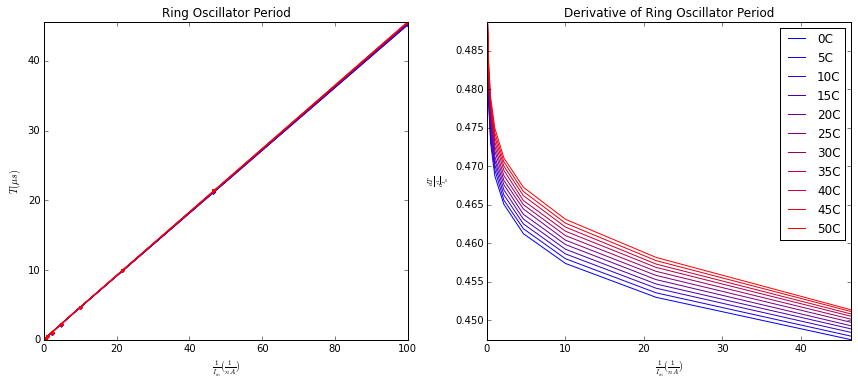

In [80]:
allTs = list(list())
globalLims = [0,0]
derivLims = [0,100000,0]

for curTemp in temps:
    fileName = "AH_TempSweep_SizedThin/AH_Inv_FreqMeas_Temp"+str(curTemp)+"C.csv"
    # Note: This run required changing the readFile function that plotLinearity uses from readFile2 to readFile3
    curTs, curFitParams = plotLinearity(fileName)
    #curTs, curFitParams = plotLinearity(fileName, Lims=(20,15))
    allTs.append(curTs)
    print 'Temp: {}\tRelative RMSE: {:%}\tParams: {}'.format(curTemp,
                                                             calcRRMSE(scaledIins, curTs, curFitParams),
                                                             curFitParams)
legend(loc='best')
tight_layout()

# Calculate the percentage variance that results from the variation in temperature.
TsAsFuncOfIin = array(allTs).T
#print TsAsFuncOfIin

print 
print '{:>5s}\t\t{:^12s}'.format("Iins", "Percent Error")
for i, curTs in enumerate(TsAsFuncOfIin):
    #print mean(curTs), max(curTs), min(curTs), std(curTs), var(curTs)
    Iins_nA = Iins[i]/10**-9
    rse = (max(curTs)-min(curTs))/mean(curTs)
    print '{:>6.3f} nA\t{:^12.3%}'.format(Iins_nA, rse)

### Thick Oxide Inverter for Slow Input Currents
Now that it looks like we have a promising candidate for the oscillator (for larger currents), we want to investigate possibilities for smaller currents.

The instinctual response to measuring smaller input currents with the same AH circuit is to try and amplify the input currents.  Sadly, ampilfying input currents has three main problems.  The first problem is that it easily creates jumps in the output if you are using some form of div-gain system.  The second is that you can't get the 1000x gain that you need to switch quickly enough for the large currents.  The third reason is that mismatch starts to kill you very quickly if you try to use any form of a chained multiplier.

As such, the first solution that we want to propose/try is changing the first inverter, in the feedback chain of inverters, to ThickFET transistors.  Then we'll test the linearity over temperature and smaller input currents.  This will allow us to see if the same benefits of the AH circuit also apply when we are using smaller transistors.  The reason we think we can get away with using ThickFETs for smaller currents is because the inverter's gain will still be much faster than the capacitor's charging speed, and as such the non-linearity introduced by the ThickFET will be a much smaller proportion of the switching time of the oscillator.  We can notice in our original nonlinearity plots  that as the currents got smaller, our linearity started to flatten out.  We're hoping that this trend stays in effect for even smaller currents.  The sweep will range from 10fA to 10pA (to cover the remaining 6 orders of magnitude.

In [82]:
paramFile = open(folderRoot+"SweptParams_SmallIins_10fAto10pA.csv")
for i, row in enumerate(csv.reader(paramFile)):
    if i==1:
        SmallIins = array(double(row[1:]))
        print "Iins: ", SmallIins
    else:
        print "Too many rows"
scaledSmallIins = SmallIins*1e12
print scaledSmallIins
invSmallIins = 1./scaledSmallIins
print invSmallIins

Too many rows
Iins:  [  1.00000000e-14   2.15443469e-14   4.64158883e-14   1.00000000e-13
   2.15443469e-13   4.64158883e-13   1.00000000e-12   2.15443469e-12
   4.64158883e-12   1.00000000e-11]
[ 0.01        0.02154435  0.04641589  0.1         0.21544347  0.46415888
  1.          2.15443469  4.64158883 10.        ]
[ 100.           46.41588834   21.5443469    10.            4.64158883
    2.15443469    1.            0.46415888    0.21544347    0.1       ]


Temp: 0	Relative RMSE: 0.202702%	Params: [ 0.44390313  0.01162853 -0.00101304]
Temp: 5	Relative RMSE: 0.176687%	Params: [ 0.44512982  0.01069216 -0.00117007]
Temp: 10	Relative RMSE: 0.134968%	Params: [ 0.44667142  0.00910524 -0.00138581]
Temp: 15	Relative RMSE: 0.097573%	Params: [ 0.44855011  0.00699135 -0.00168598]
Temp: 20	Relative RMSE: 0.122152%	Params: [ 0.4508849   0.00417289 -0.00211415]
Temp: 25	Relative RMSE: 0.215199%	Params: [ 0.45373621  0.00075096 -0.00272995]
Temp: 30	Relative RMSE: 0.347614%	Params: [ 0.45724449 -0.00332891 -0.00362497]
Temp: 35	Relative RMSE: 0.493944%	Params: [ 0.4613524  -0.00762758 -0.00491687]
Temp: 40	Relative RMSE: 0.649489%	Params: [ 0.46606834 -0.01188806 -0.00677558]
Temp: 45	Relative RMSE: 0.778980%	Params: [ 0.47113808 -0.01536277 -0.00941484]
Temp: 50	Relative RMSE: 0.855132%	Params: [ 0.47622189 -0.01742964 -0.01312144]

 Iins		Percent Error
 0.010 pA	  59.111%   
 0.022 pA	  33.021%   
 0.046 pA	  15.557%   
 0.100 pA	   6.116%   
 0.215 p

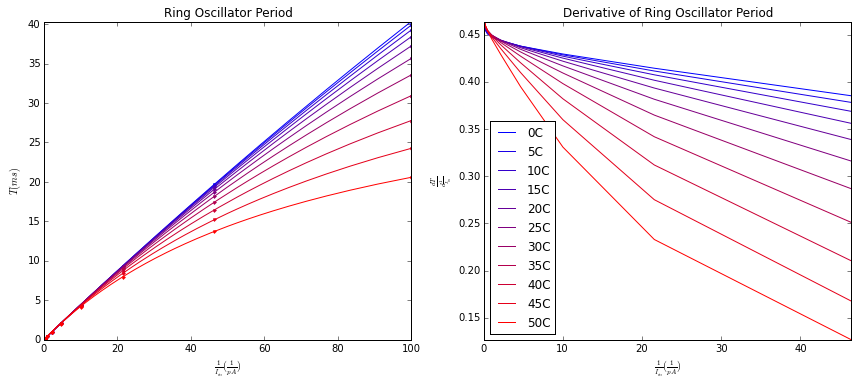

In [83]:
allTs = list(list())
globalLims = [0,0]
derivLims = [0,100000,0]

for curTemp in temps:
    fileName = "AH_TempSweep_SmallIin_10fAto10pA/AH_Inv_FreqMeas_Temp"+str(curTemp)+"C.csv"
    # Note: This run required changing the readFile function that plotLinearity uses from readFile2 to readFile3
    curTs, curFitParams = plotLinearitySmallIins(fileName,Lims=None)
    #curTs, curFitParams = plotLinearitySmallIins(fileName, Lims=(20,10))
    allTs.append(curTs)
    print 'Temp: {}\tRelative RMSE: {:%}\tParams: {}'.format(curTemp,
                                                             calcRRMSE(scaledSmallIins, curTs, curFitParams),
                                                             curFitParams)
legend(loc='best')
tight_layout()

# Calculate the percentage variance that results from the variation in temperature.
TsAsFuncOfIin = array(allTs).T
#print TsAsFuncOfIin

print
print '{:>5s}\t\t{:^12s}'.format("Iins", "Percent Error")
for i, curTs in enumerate(TsAsFuncOfIin):
    #print mean(curTs), max(curTs), min(curTs), std(curTs), var(curTs)
    Iins_pA = SmallIins[i]/10**-12
    rse = (max(curTs)-min(curTs))/mean(curTs)
    print '{:>6.3f} pA\t{:^12.3%}'.format(Iins_pA, rse)

#### Revised Small $I_{in}$ sweep for initial thickFET inverter configuration

Based on this initial run, we see that using the Thick Oxide inverter results in a large dependence on temperature at smaller currents.  After talking to Ben about this quickly, he suggested that we actually look at currents from 100fA to 10pA, b/c we won't ever need to measure currents as small as 10fA.  He also said that there is a $\kappa$ dependence at really small currents that causes for this massive dependence on temperature.  He says this because he noticed, empirically from this simulations, that when $V_{gs}$ is small ($< 100mV$) $\kappa$ started to rise.  

As such, the simulation below shows the results of sweeping from just 100fA to 10pA, while varying the temperature from $0^{\circ} C$ to $50^{\circ} C$

In [84]:
paramFile = open(folderRoot+"SweptParams_SmallIins.csv")
for i, row in enumerate(csv.reader(paramFile)):
    if i==1:
        SmallIins = array(double(row[1:]))
        print "Iins: ", SmallIins
    else:
        print "Too many rows"
scaledSmallIins = SmallIins*1e12
print scaledSmallIins
invSmallIins = 1./scaledSmallIins
print invSmallIins

Too many rows
Iins:  [  1.00000000e-13   1.77827941e-13   3.16227766e-13   5.62341325e-13
   1.00000000e-12   1.77827941e-12   3.16227766e-12   5.62341325e-12
   1.00000000e-11]
[  0.1          0.17782794   0.31622777   0.56234133   1.           1.77827941
   3.16227766   5.62341325  10.        ]
[ 10.           5.62341325   3.16227766   1.77827941   1.           0.56234133
   0.31622777   0.17782794   0.1       ]


Temp: 0	Relative RMSE: 0.097387%	Params: [ 0.45001745  0.00352943 -0.00195557]
Temp: 5	Relative RMSE: 0.095801%	Params: [ 0.45079024  0.00344269 -0.00206829]
Temp: 10	Relative RMSE: 0.094785%	Params: [ 0.45156584  0.00336215 -0.0022114 ]
Temp: 15	Relative RMSE: 0.093869%	Params: [ 0.45235264  0.00329751 -0.00241277]
Temp: 20	Relative RMSE: 0.090240%	Params: [ 0.45319653  0.00320105 -0.00269823]
Temp: 25	Relative RMSE: 0.086516%	Params: [ 0.45407333  0.00310151 -0.00310214]
Temp: 30	Relative RMSE: 0.079615%	Params: [ 0.4550714   0.00295854 -0.00371009]
Temp: 35	Relative RMSE: 0.069654%	Params: [ 0.45621891  0.00275757 -0.00461596]
Temp: 40	Relative RMSE: 0.053565%	Params: [ 0.45766661  0.00243613 -0.00600523]
Temp: 45	Relative RMSE: 0.034760%	Params: [ 0.45946043  0.00200793 -0.00807921]
Temp: 50	Relative RMSE: 0.025568%	Params: [ 0.46166687  0.00145915 -0.01114843]

 Iins		Percent Error
 0.100 pA	   6.116%   
 0.178 pA	   2.683%   
 0.316 pA	   1.011%   
 0.562 pA	   0.731%   
 1.000 p

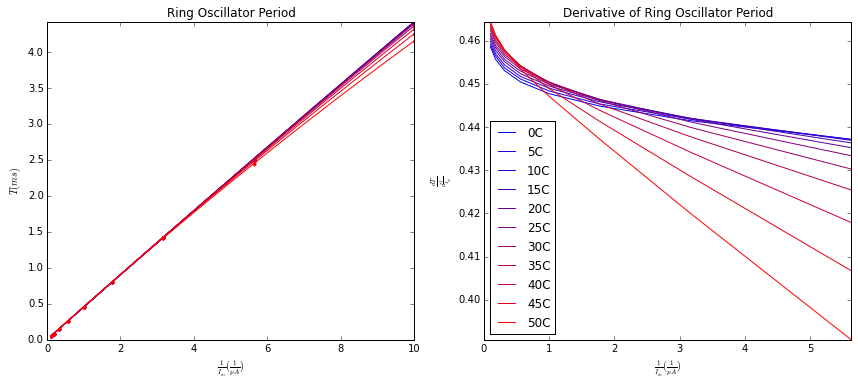

In [85]:
allTs = list(list())
globalLims = [0,0]
derivLims = [0,100000,0]

for curTemp in temps:
    fileName = "AH_TempSweep_SmallIin/AH_Inv_FreqMeas_Temp"+str(curTemp)+"C.csv"
    # Note: This run required changing the readFile function that plotLinearity uses from readFile2 to readFile3
    curTs, curFitParams = plotLinearitySmallIins(fileName,Lims=None)
    #curTs, curFitParams = plotLinearitySmallIins(fileName, Lims=(20,10))
    allTs.append(curTs)
    print 'Temp: {}\tRelative RMSE: {:%}\tParams: {}'.format(curTemp,
                                                             calcRRMSE(scaledSmallIins, curTs, curFitParams),
                                                             curFitParams)
legend(loc='best')
tight_layout()

# Calculate the percentage variance that results from the variation in temperature.
TsAsFuncOfIin = array(allTs).T
#print TsAsFuncOfIin

print
print '{:>5s}\t\t{:^12s}'.format("Iins", "Percent Error")
for i, curTs in enumerate(TsAsFuncOfIin):
    #print mean(curTs), max(curTs), min(curTs), std(curTs), var(curTs)
    Iins_pA = SmallIins[i]/10**-12
    rse = (max(curTs)-min(curTs))/mean(curTs)
    print '{:>6.3f} pA\t{:^12.3%}'.format(Iins_pA, rse)

#### Longer Channel ThickFET Inverter for Small Input Currents
After talking to Ben, we think that the reason for this current dependence has to do with some $\kappa$ dependence on temperature at small $V_{gs}$ values.  We still can't fully understand why this would be the case, but one explanation was that $\kappa$ isn't actually varying with temperature, but instead that the Early Voltage is depending with temperature and is significantly different when $V_{gs}$ is small over temperature.

As such, in this next run, we went back to using 3L ThickFET transistors in the first inverter, so that the Early voltage effect is mitigated.  We are then hoping that this will result in less temperature variance for small input currents.

Temp: 0	Relative RMSE: 0.116768%	Params: [ 0.45246824  0.00516172 -0.00204038]
Temp: 5	Relative RMSE: 0.111331%	Params: [ 0.45321333  0.0048489  -0.00215049]
Temp: 10	Relative RMSE: 0.107796%	Params: [ 0.45394087  0.00459808 -0.00228789]
Temp: 15	Relative RMSE: 0.104716%	Params: [ 0.45468002  0.00438426 -0.00246986]
Temp: 20	Relative RMSE: 0.100772%	Params: [ 0.45547745  0.00418248 -0.00274274]
Temp: 25	Relative RMSE: 0.096405%	Params: [ 0.45634411  0.00397404 -0.00313762]
Temp: 30	Relative RMSE: 0.089237%	Params: [ 0.45728876  0.00375758 -0.00373204]
Temp: 35	Relative RMSE: 0.077245%	Params: [ 0.45848386  0.00345837 -0.00464633]
Temp: 40	Relative RMSE: 0.060281%	Params: [ 0.45992781  0.00307499 -0.00602618]
Temp: 45	Relative RMSE: 0.041405%	Params: [ 0.46171236  0.00259886 -0.00809745]
Temp: 50	Relative RMSE: 0.026573%	Params: [ 0.46396902  0.00198591 -0.01117265]

 Iins		Percent Error
 0.100 pA	   6.106%   
 0.178 pA	   2.691%   
 0.316 pA	   1.020%   
 0.562 pA	   0.554%   
 1.000 p

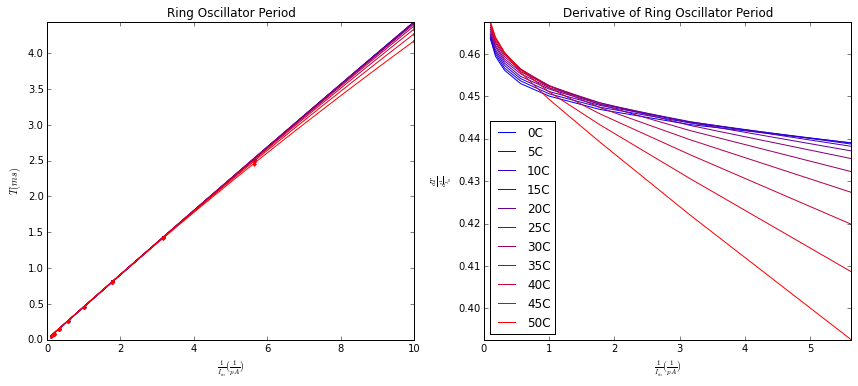

In [86]:
allTs = list(list())
globalLims = [0,0]
derivLims = [0,100000,0]

for curTemp in temps:
    fileName = "AH_TempSweep_SmallIin/AH_Inv_FreqMeas_Temp"+str(curTemp)+"C_3LInv.csv"
    # Note: This run required changing the readFile function that plotLinearity uses from readFile2 to readFile3
    curTs, curFitParams = plotLinearitySmallIins(fileName,Lims=None)
    #curTs, curFitParams = plotLinearitySmallIins(fileName, Lims=(20,10))
    allTs.append(curTs)
    print 'Temp: {}\tRelative RMSE: {:%}\tParams: {}'.format(curTemp,
                                                             calcRRMSE(scaledSmallIins, curTs, curFitParams),
                                                             curFitParams)
legend(loc='best')
tight_layout()

# Calculate the percentage variance that results from the variation in temperature.
TsAsFuncOfIin = array(allTs).T
#print TsAsFuncOfIin

print
print '{:>5s}\t\t{:^12s}'.format("Iins", "Percent Error")
for i, curTs in enumerate(TsAsFuncOfIin):
    #print mean(curTs), max(curTs), min(curTs), std(curTs), var(curTs)
    Iins_pA = SmallIins[i]/10**-12
    rse = (max(curTs)-min(curTs))/mean(curTs)
    print '{:>6.3f} pA\t{:^12.3%}'.format(Iins_pA, rse)

In the results above, using the ThickFET 3L transistors for the first inverter doesn't really resolve any of the temperature dependence at small currents.  As a matter of fact, it looks like it didn't affect almost at all.  This is evidence that the Early Voltage isn't temperature dependent, or at least that trying to tighten the dependence on the Early Voltage doesn't really help us.

I noticed that in the past that I didn't have all of my power rails named the same (vddd!\* vs vdda!, and gndd!\* vs gnda!), and this messed with some of my simulations ability to simulate accurately.  As such, I wanted to change the inverters' power rails to match the rest of the circuit to see if that changes the simulation at all.  The results below show these results.

These results basically show that the way my power rails were acting was accurate, and didn't change anything.

In [87]:
paramFile = open(folderRoot+"SweptParams_SmallIins_LessSweeps.csv")
for i, row in enumerate(csv.reader(paramFile)):
    if i == 0:
        LessTemps = array(row[1:])
        print "Temps: ", LessTemps
    elif i==1:
        SmallIins = array(double(row[1:]))
        print "Iins: ", SmallIins
    else:
        print "Too many rows"
scaledSmallIins = SmallIins*1e12
print scaledSmallIins
invSmallIins = 1./scaledSmallIins
print invSmallIins

Temps:  ['0' '12.5' '25' '37.5' '50']
Iins:  [  1.00000000e-13   2.15443469e-13   4.64158883e-13   1.00000000e-12
   2.15443469e-12   4.64158883e-12   1.00000000e-11]
[ 0.1         0.21544347  0.46415888  1.          2.15443469  4.64158883
 10.        ]
[ 10.           4.64158883   2.15443469   1.           0.46415888
   0.21544347   0.1       ]


Temp: 0	Relative RMSE: 0.108206%	Params: [ 0.4526309   0.00496645 -0.00206547]
Temp: 12.5	Relative RMSE: 0.099663%	Params: [ 0.45445756  0.00431558 -0.00238955]
Temp: 25	Relative RMSE: 0.090814%	Params: [ 0.45647496  0.00382178 -0.00316435]
Temp: 37.5	Relative RMSE: 0.067951%	Params: [ 0.45922732  0.00318394 -0.00527383]
Temp: 50	Relative RMSE: 0.024628%	Params: [ 0.46392817  0.00199824 -0.01116375]

 Iins		Percent Error
 0.100 pA	   6.125%   
 0.215 pA	   1.984%   
 0.464 pA	   0.494%   
 1.000 pA	   0.596%   
 2.154 pA	   0.503%   
 4.642 pA	   0.233%   
10.000 pA	   1.044%   


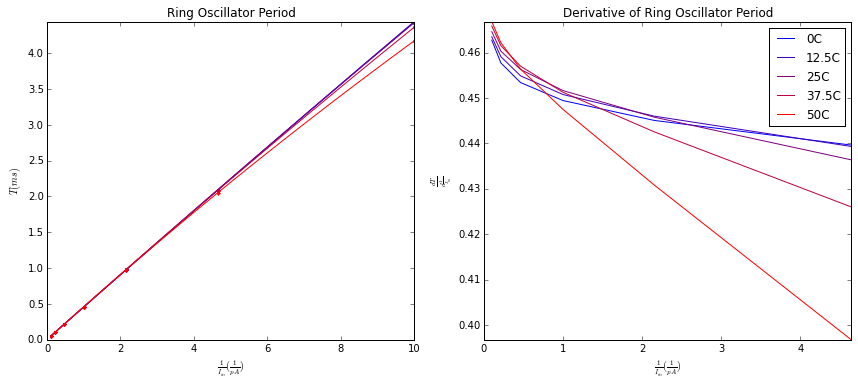

In [88]:
allTs = list(list())
globalLims = [0,0]
derivLims = [0,100000,0]

for curTemp in LessTemps:
    fileName = "AH_TempSweep_SmallIin_CommonPowerRails/AH_Inv_FreqMeas_Temp"+str(curTemp)+"C_3LInv.csv"
    # Note: This run required changing the readFile function that plotLinearity uses from readFile2 to readFile3
    curTs, curFitParams = plotLinearitySmallIins(fileName,Lims=None)
    #curTs, curFitParams = plotLinearitySmallIins(fileName, Lims=(20,10))
    allTs.append(curTs)
    print 'Temp: {}\tRelative RMSE: {:%}\tParams: {}'.format(curTemp,
                                                             calcRRMSE(scaledSmallIins, curTs, curFitParams),
                                                             curFitParams)
legend(loc='best')
tight_layout()

# Calculate the percentage variance that results from the variation in temperature.
TsAsFuncOfIin = array(allTs).T
#print TsAsFuncOfIin

print
print '{:>5s}\t\t{:^12s}'.format("Iins", "Percent Error")
for i, curTs in enumerate(TsAsFuncOfIin):
    #print mean(curTs), max(curTs), min(curTs), std(curTs), var(curTs)
    Iins_pA = SmallIins[i]/10**-12
    rse = (max(curTs)-min(curTs))/mean(curTs)
    print '{:>6.3f} pA\t{:^12.3%}'.format(Iins_pA, rse)

#### Complex Mirror to set the current sources
In talking out the problem with Kwabena and Ben, we realized that the problem might be occuring because our current mirror isn't mirroring current accurately due to vastly different $V_{ds}$ voltages on each side of the mirror.  As such, we want to try out complex mirrors (cascoded mirrors) to see if they help the design behave more linearly with small currents while varying temperature.

To phrase the problem more accurately, at small input currents, the $V_{gs}$ voltage was hovering around 85-195mV as you varied the temperature.   This means that the $V_{ds}$ voltage of the bias side of the mirror is also the same 85-195mV, while we know that the other side has t$V_{ds} = V_{cap}$, where $V_{cap}$ is roughly around 400-500mV regardless of temperature.  This difference in $V_{ds}$ voltages might be accounting for the variation in temperature, because we see, experimentally, that the Early voltage slope changes with temperature.

Temp: 0	Relative RMSE: 0.048244%	Params: [  5.07166630e-01   2.99424347e-03  -4.88165366e-04]
Temp: 12.5	Relative RMSE: 0.039687%	Params: [ 0.51556939  0.00239163 -0.00060478]
Temp: 25	Relative RMSE: 0.031358%	Params: [ 0.52402702  0.00194294 -0.00093308]
Temp: 37.5	Relative RMSE: 0.019058%	Params: [ 0.53265748  0.00150845 -0.00178132]
Temp: 50	Relative RMSE: 0.017657%	Params: [ 0.54228145  0.00079152 -0.00419403]

 Iins		Percent Error
 0.100 pA	   3.579%   
 0.215 pA	   4.927%   
 0.464 pA	   5.593%   
 1.000 pA	   5.688%   
 2.154 pA	   5.453%   
 4.642 pA	   4.911%   
10.000 pA	   4.380%   


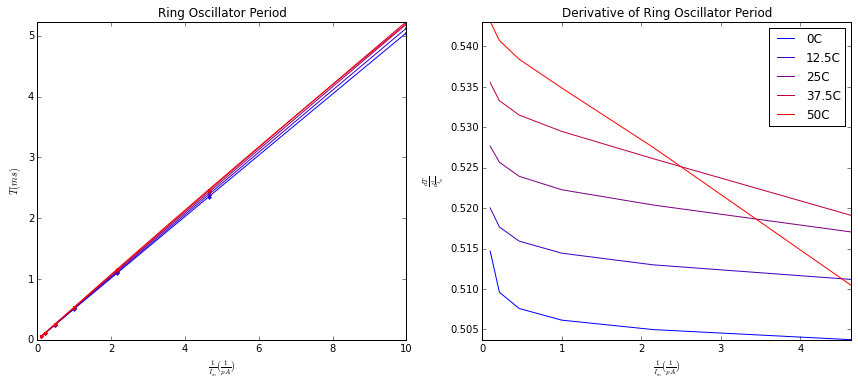

In [89]:
allTs = list(list())
globalLims = [0,0]
derivLims = [0,100000,0]

for curTemp in LessTemps:
    fileName = "AH_TempSweep_SmallIin_CascodedMirrors/AH_Inv_FreqMeas_Temp"+str(curTemp)+"C_3LInv.csv"
    # Note: This run required changing the readFile function that plotLinearity uses from readFile2 to readFile3
    curTs, curFitParams = plotLinearitySmallIins(fileName,Lims=None)
    #curTs, curFitParams = plotLinearitySmallIins(fileName, Lims=(20,10))
    allTs.append(curTs)
    print 'Temp: {}\tRelative RMSE: {:%}\tParams: {}'.format(curTemp,
                                                             calcRRMSE(scaledSmallIins, curTs, curFitParams),
                                                             curFitParams)
legend(loc='best')
tight_layout()

# Calculate the percentage variance that results from the variation in temperature.
TsAsFuncOfIin = array(allTs).T
#print TsAsFuncOfIin

print
print '{:>5s}\t\t{:^12s}'.format("Iins", "Percent Error")
for i, curTs in enumerate(TsAsFuncOfIin):
    #print mean(curTs), max(curTs), min(curTs), std(curTs), var(curTs)
    Iins_pA = SmallIins[i]/10**-12
    rse = (max(curTs)-min(curTs))/mean(curTs)
    print '{:>6.3f} pA\t{:^12.3%}'.format(Iins_pA, rse)

As we can see, using the cascoded mirrors didn't work well.  We think that the reason this didn't work is because we ran out of headroom at the larger currents.  As such, we want to figure out a way to get more headroom.  What Ben helped me realize is that we can do this by changing the current sources from 3L to 1L, which helps us set a current using a smaller $V_{gs}$ value.  This will hopefully help with the headroom for currents as large as 10pA.

In [8]:
paramFile = open(folderRoot+"SweptParams_SmallIins_QuickSweep.csv")
for i, row in enumerate(csv.reader(paramFile)):
    if i == 0:
        LessTemps = array(row[1:])
        print "Temps: ", LessTemps
    elif i==1:
        SmallIins = array(double(row[1:]))
        print "Iins: ", SmallIins
    else:
        print "Too many rows"
scaledSmallIins = SmallIins*1e12
print scaledSmallIins
invSmallIins = 1./scaledSmallIins
print invSmallIins

Temps:  ['0' '25' '50']
Iins:  [  1.00000000e-13   3.16227766e-13   1.00000000e-12   3.16227766e-12
   1.00000000e-11]
[  0.1          0.31622777   1.           3.16227766  10.        ]
[ 10.           3.16227766   1.           0.31622777   0.1       ]


Temp: 0	Relative RMSE: 0.032382%	Params: [ 0.22155405  0.0025002  -0.00066058]
Temp: 25	Relative RMSE: 0.020309%	Params: [ 0.2226095   0.00133022 -0.00124663]
Temp: 50	Relative RMSE: 0.048980%	Params: [  2.26484453e-01  -4.05004033e-05  -9.54960736e-03]

 Iins		Percent Error
 0.100 pA	   6.313%   
 0.316 pA	   0.988%   
 1.000 pA	   0.397%   
 3.162 pA	   1.658%   
10.000 pA	   5.285%   


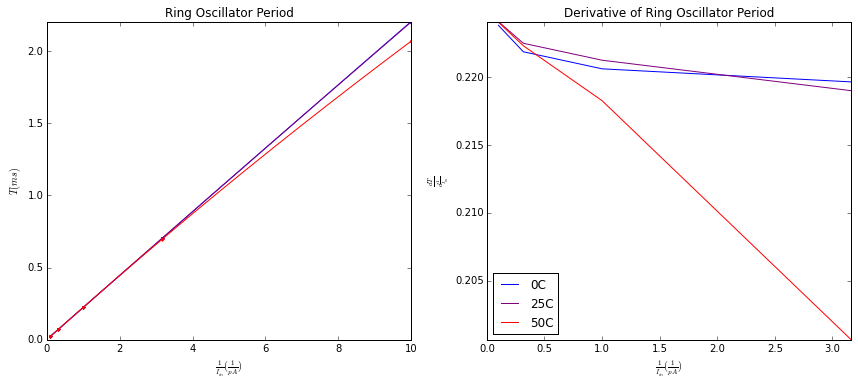

In [91]:
allTs = list(list())
globalLims = [0,0]
derivLims = [0,100000,0]

for curTemp in LessTemps:
    fileName = "AH_TempSweep_SmallIin_CascodedMirrors/AH_Inv_FreqMeas_Temp"+str(curTemp)+"C_3LInv_2W1LCS.csv"
    # Note: This run required changing the readFile function that plotLinearity uses from readFile2 to readFile3
    curTs, curFitParams = plotLinearitySmallIins(fileName,Lims=None)
    #curTs, curFitParams = plotLinearitySmallIins(fileName, Lims=(2,1))
    allTs.append(curTs)
    print 'Temp: {}\tRelative RMSE: {:%}\tParams: {}'.format(curTemp,
                                                             calcRRMSE(scaledSmallIins, curTs, curFitParams),
                                                             curFitParams)
legend(loc='best')
tight_layout()

# Calculate the percentage variance that results from the variation in temperature.
TsAsFuncOfIin = array(allTs).T
#print TsAsFuncOfIin

print
print '{:>5s}\t\t{:^12s}'.format("Iins", "Percent Error")
for i, curTs in enumerate(TsAsFuncOfIin):
    #print mean(curTs), max(curTs), min(curTs), std(curTs), var(curTs)
    Iins_pA = SmallIins[i]/10**-12
    rse = (max(curTs)-min(curTs))/mean(curTs)
    print '{:>6.3f} pA\t{:^12.3%}'.format(Iins_pA, rse)

Based on the evidence above, we see that using the 1L (150nm length) transistors, gets us back to where we started, except for at 10pA, which is still in the region where it looks like we are running into headroom issues.  With that said, it also shows us that the 6% error we were seeing before is still in the circuit, and this helps us to realize that the temperature variation isn't necessarily coming from the inaccurate current mirror.

It should also be noted that when we went to the 1L design, the overall design operated faster.  I'm not 100% sure why this is the case, but part of the reason might be that the there is less overall capacitance on the $V_{cap}$ node, and as such it takes less time to charge and discharge that node.  This is empirically seen in the simulation where $V_{cap}$ now varies from ~440mV to ~500mV, whereas with the 3L configuration, $V_{cap}$ varies from ~420mV to ~520mV.  _It should be noted that there is something that is counter-intuitive here; with the 3L configuration, there should be more capacitance on the $V_{cap}$ line, and therefore $\delta V$ should be smaller than with the 1L configuration._

As a side experiment, I wanted to go back to using 3L (450nm length) transistors for the current sources, so that I can clearly show that, everything else being the same, the longer channel configuration hurts the overall temperature dependence, theoretically because of the loss of headroom.

Temp: 0	Relative RMSE: 0.041239%	Params: [ 0.50747179  0.00273343 -0.00054151]
Temp: 25	Relative RMSE: 0.028799%	Params: [ 0.52414569  0.00181485 -0.00094794]
Temp: 50	Relative RMSE: 0.005873%	Params: [ 0.54206019  0.00090967 -0.00415434]

 Iins		Percent Error
 0.100 pA	   3.013%   
 0.316 pA	   5.358%   
 1.000 pA	   5.692%   
 3.162 pA	   5.196%   
10.000 pA	   4.367%   


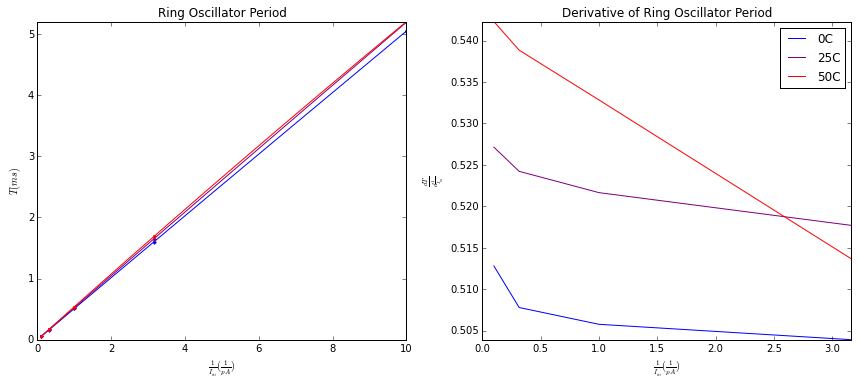

In [92]:
allTs = list(list())
globalLims = [0,0]
derivLims = [0,100000,0]

for curTemp in LessTemps:
    fileName = "AH_TempSweep_SmallIin_CascodedMirrors/AH_Inv_FreqMeas_Temp"+str(curTemp)+"C_3LInv_2W3LCS.csv"
    # Note: This run required changing the readFile function that plotLinearity uses from readFile2 to readFile3
    curTs, curFitParams = plotLinearitySmallIins(fileName,Lims=None)
    #curTs, curFitParams = plotLinearitySmallIins(fileName, Lims=(2,1))
    allTs.append(curTs)
    print 'Temp: {}\tRelative RMSE: {:%}\tParams: {}'.format(curTemp,
                                                             calcRRMSE(scaledSmallIins, curTs, curFitParams),
                                                             curFitParams)
legend(loc='best')
tight_layout()

# Calculate the percentage variance that results from the variation in temperature.
TsAsFuncOfIin = array(allTs).T
#print TsAsFuncOfIin

print
print '{:>5s}\t\t{:^12s}'.format("Iins", "Percent Error")
for i, curTs in enumerate(TsAsFuncOfIin):
    #print mean(curTs), max(curTs), min(curTs), std(curTs), var(curTs)
    Iins_pA = SmallIins[i]/10**-12
    rse = (max(curTs)-min(curTs))/mean(curTs)
    print '{:>6.3f} pA\t{:^12.3%}'.format(Iins_pA, rse)

## Temperature dependence debugging
In this section we continue our debugging from above, but we do so in a more systematic way.  This will entail using ideal components again, trying a shifted voltage bias (based on sub-pico ampere circuits), and/or analyzing critical values in the circuit.


_Note: To speed up simulation time, I am going to continue to do abridged sweeps of temperatures and $I_{in}$.  Temperature will be swept from $0^{\circ}C-50^{\circ}C$ in 3 equal steps, and input current will have 5 logarithmic steps from 100fA to 10pA._

### Current state of affairs
In the following simulation, I am recreating the results to essentially reset the baseline.  This does two things.  It reestablishes what the "ground zero" point is for the following tests, and it allows us to ensure that I didn't change anything dramatically from the previous tests.

This first "ground zero" circuit is as follows:

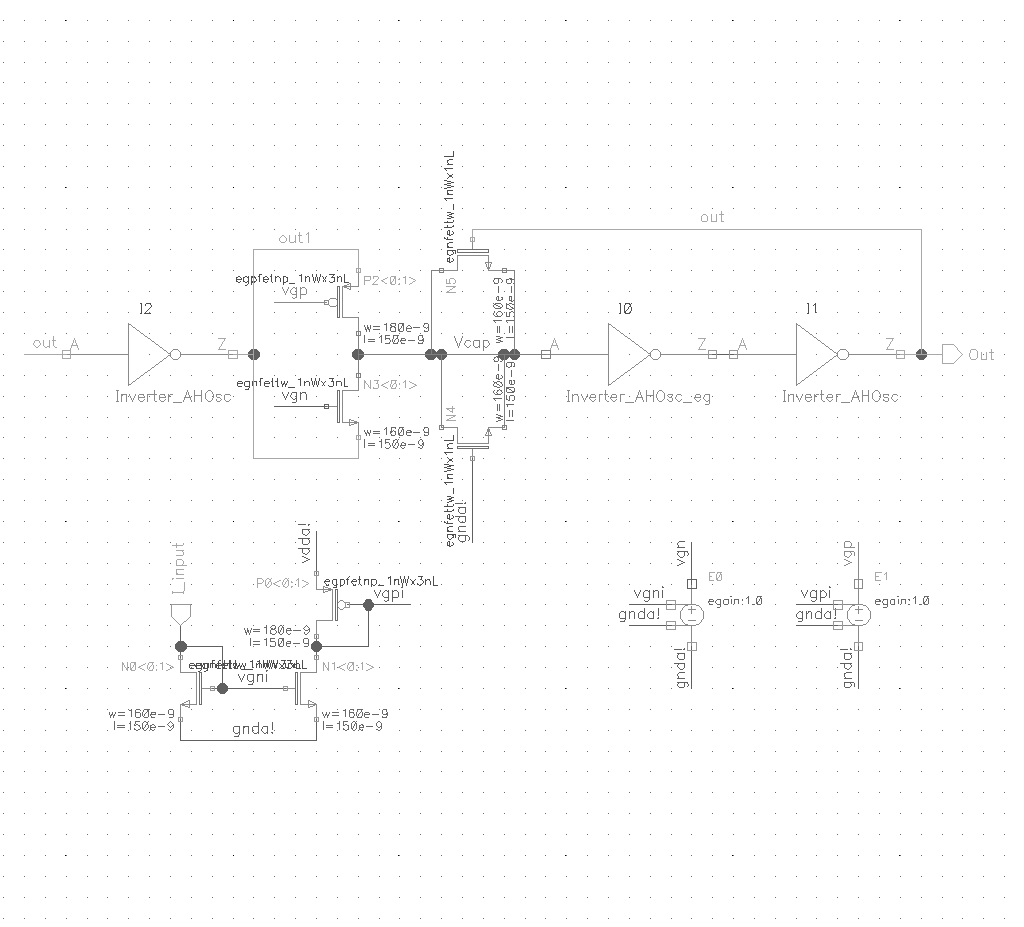

In [8]:
from IPython.display import Image
filePath = "/home/noza/work/Braindrop/CDB/BDTests/AHOsc_test/Measurements/SchematicImages/"
Image(filename = filePath + "AHBaseConfig.png", width=800)

In the circuit above, $C_1$ is implemented using transistor $N4$ and $C_2$ using $N5$.  Also, $I0$ is using 1L long ThickFET transistors for the inverter.  Similarly, $I1$ and $I2$, are implemented using 1L long ThinFET transistors.

Temp: 0	Relative RMSE: 0.054453%	Params: [ 0.2478314   0.00187928 -0.00182181]
Temp: 25	Relative RMSE: 0.049128%	Params: [ 0.24796996  0.00156254 -0.00275   ]
Temp: 50	Relative RMSE: 0.019650%	Params: [ 0.24951396  0.0009618  -0.00985785]

 Iins		Percent Error
 0.100 pA	   6.893%   
 0.316 pA	   1.899%   
 1.000 pA	   0.740%   
 3.162 pA	   0.738%   
10.000 pA	   1.406%   


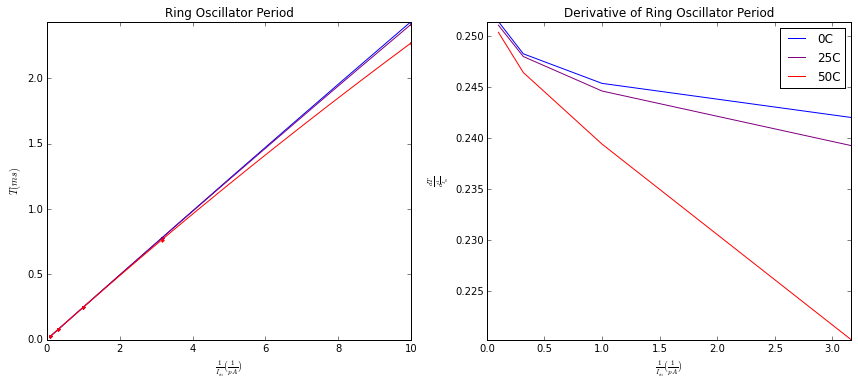

In [93]:
allTs = list(list())
globalLims = [0,0]
derivLims = [0,100000,0]

for curTemp in LessTemps:
    fileName = "AH_TempSweep_SmallIin_Systematic/AH_Inv_FreqMeas_Temp"+str(curTemp)+"C_Baseline.csv"
    # Note: This run required changing the readFile function that plotLinearity uses from readFile2 to readFile3
    curTs, curFitParams = plotLinearitySmallIins(fileName,Lims=None)
    #curTs, curFitParams = plotLinearitySmallIins(fileName, Lims=(2,1))
    allTs.append(curTs)
    print 'Temp: {}\tRelative RMSE: {:%}\tParams: {}'.format(curTemp,
                                                             calcRRMSE(scaledSmallIins, curTs, curFitParams),
                                                             curFitParams)
legend(loc='best')
tight_layout()

# Calculate the percentage variance that results from the variation in temperature.
TsAsFuncOfIin = array(allTs).T
#print TsAsFuncOfIin

print
print '{:>5s}\t\t{:^12s}'.format("Iins", "Percent Error")
for i, curTs in enumerate(TsAsFuncOfIin):
    #print mean(curTs), max(curTs), min(curTs), std(curTs), var(curTs)
    Iins_pA = SmallIins[i]/10**-12
    rse = (max(curTs)-min(curTs))/mean(curTs)
    print '{:>6.3f} pA\t{:^12.3%}'.format(Iins_pA, rse)

It should be noted that these results don't match from above exactly -- the firing rate is almost 2x as fast as above -- because in this new baseline, we are using buffers for the gate voltages of the current sources.  This difference can be seen in the results below.

Temp: 0	Relative RMSE: 0.068752%	Params: [ 0.45073549  0.0029078  -0.00209417]
Temp: 25	Relative RMSE: 0.063368%	Params: [ 0.45468572  0.00256375 -0.00321944]
Temp: 50	Relative RMSE: 0.022071%	Params: [ 0.46149526  0.00150912 -0.01111224]

 Iins		Percent Error
 0.100 pA	   6.076%   
 0.316 pA	   1.000%   
 1.000 pA	   0.896%   
 3.162 pA	   1.092%   
10.000 pA	   0.765%   


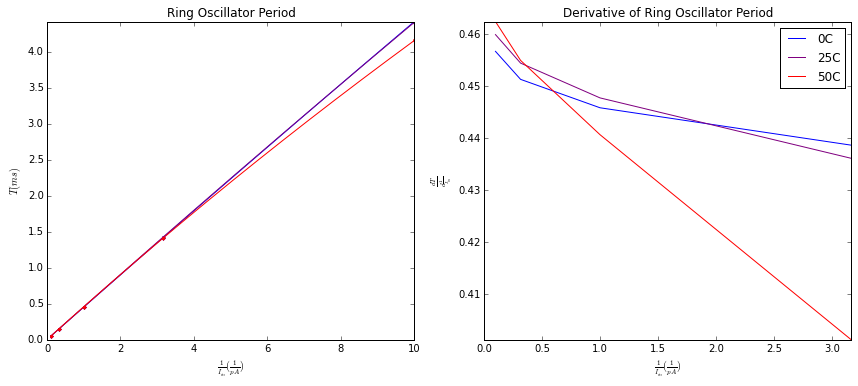

In [94]:
allTs = list(list())
globalLims = [0,0]
derivLims = [0,100000,0]

for curTemp in LessTemps:
    fileName = "AH_TempSweep_SmallIin_Systematic/AH_Inv_FreqMeas_Temp"+str(curTemp)+"C_Baseline_NoBuffer.csv"
    # Note: This run required changing the readFile function that plotLinearity uses from readFile2 to readFile3
    curTs, curFitParams = plotLinearitySmallIins(fileName,Lims=None)
    #curTs, curFitParams = plotLinearitySmallIins(fileName, Lims=(2,1))
    allTs.append(curTs)
    print 'Temp: {}\tRelative RMSE: {:%}\tParams: {}'.format(curTemp,
                                                             calcRRMSE(scaledSmallIins, curTs, curFitParams),
                                                             curFitParams)
legend(loc='best')
tight_layout()

# Calculate the percentage variance that results from the variation in temperature.
TsAsFuncOfIin = array(allTs).T
#print TsAsFuncOfIin

print
print '{:>5s}\t\t{:^12s}'.format("Iins", "Percent Error")
for i, curTs in enumerate(TsAsFuncOfIin):
    #print mean(curTs), max(curTs), min(curTs), std(curTs), var(curTs)
    Iins_pA = SmallIins[i]/10**-12
    rse = (max(curTs)-min(curTs))/mean(curTs)
    print '{:>6.3f} pA\t{:^12.3%}'.format(Iins_pA, rse)

### Simple Mirror with ideal components
Because we noticed that having the complex mirror doesn't really help the 6% temperature dependence at small currents, we want to start this phase of systematic testing with our original configuration using a simple mirror.
#### Ideal caps
The first test we want to perform is having ideal capacitors to eliminate any effects temperature might have on the capacitance of the MOS Caps.  The ideal caps $C_1$ and $C_2$ are sized to be 150aF, to roughly approximate the capacitance of an Reverse Body Biased NFET MOS Cap with a small $V_{gs}$ value.

Temp: 0	Relative RMSE: 0.058056%	Params: [ 0.33596303  0.00222689 -0.00184768]
Temp: 25	Relative RMSE: 0.053520%	Params: [ 0.33545544  0.00191446 -0.00281184]
Temp: 50	Relative RMSE: 0.020869%	Params: [ 0.33684651  0.00117396 -0.00996983]

 Iins		Percent Error
 0.100 pA	   7.373%   
 0.316 pA	   2.322%   
 1.000 pA	   1.087%   
 3.162 pA	   0.962%   
10.000 pA	   1.412%   


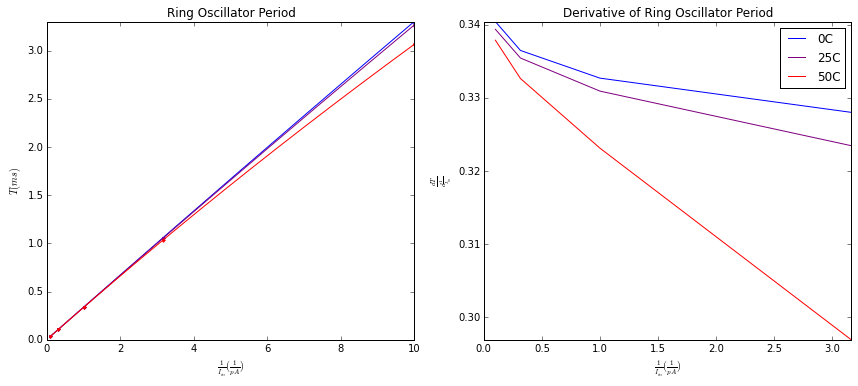

In [95]:
allTs = list(list())
globalLims = [0,0]
derivLims = [0,100000,0]

for curTemp in LessTemps:
    fileName = "AH_TempSweep_SmallIin_Systematic/AH_Inv_FreqMeas_Temp"+str(curTemp)+"C_Baseline_IdealCaps.csv"
    # Note: This run required changing the readFile function that plotLinearity uses from readFile2 to readFile3
    curTs, curFitParams = plotLinearitySmallIins(fileName,Lims=None)
    #curTs, curFitParams = plotLinearitySmallIins(fileName, Lims=(2,1))
    allTs.append(curTs)
    print 'Temp: {}\tRelative RMSE: {:%}\tParams: {}'.format(curTemp,
                                                             calcRRMSE(scaledSmallIins, curTs, curFitParams),
                                                             curFitParams)
legend(loc='best')
tight_layout()

# Calculate the percentage variance that results from the variation in temperature.
TsAsFuncOfIin = array(allTs).T
#print TsAsFuncOfIin

print
print '{:>5s}\t\t{:^12s}'.format("Iins", "Percent Error")
for i, curTs in enumerate(TsAsFuncOfIin):
    #print mean(curTs), max(curTs), min(curTs), std(curTs), var(curTs)
    Iins_pA = SmallIins[i]/10**-12
    rse = (max(curTs)-min(curTs))/mean(curTs)
    print '{:>6.3f} pA\t{:^12.3%}'.format(Iins_pA, rse)

#### Ideal inverters and ideal caps
In this test, we are going to make the inverters ideal, by having them operate as inverting vcvs, with a bias set at 0.5 (roughly equal to the inversion voltage).  This will essentially have the circuit broken down to just 2 main components, two current sources and their biasing circuits.  Everything else should be ideal and should therefore be immune to temperature.  (_Note: I am  making an assumption that ideal elements are immune to temperature variations and haven't verified this assumption_).  The results of this test should help us better establish whether the temperature variance is coming from the current sources and biasing circuits.

Temp: 0	Relative RMSE: 0.053961%	Params: [ 0.37527575  0.00174656 -0.00172706]
Temp: 25	Relative RMSE: 0.051887%	Params: [ 0.37908518  0.00174481 -0.00275404]
Temp: 50	Relative RMSE: 0.018570%	Params: [ 0.38535135  0.00105093 -0.00992352]

 Iins		Percent Error
 0.100 pA	   5.079%   
 0.316 pA	   0.689%   
 1.000 pA	   1.427%   
 3.162 pA	   1.825%   
10.000 pA	   1.959%   


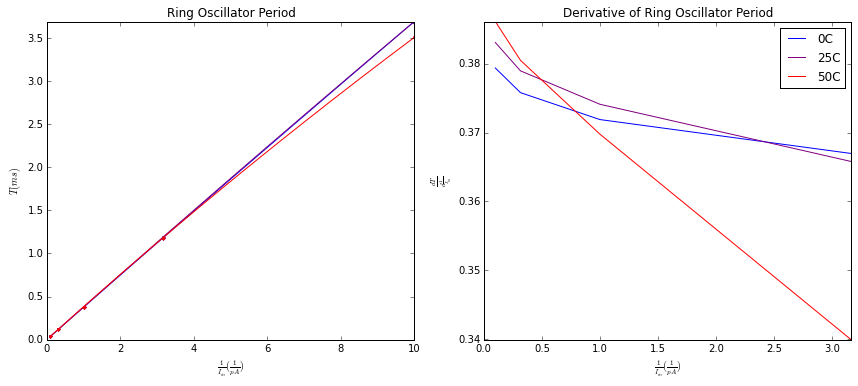

In [96]:
allTs = list(list())
globalLims = [0,0]
derivLims = [0,100000,0]

for curTemp in LessTemps:
    fileName = "AH_TempSweep_SmallIin_Systematic/AH_Inv_FreqMeas_Temp"+str(curTemp)+"C_Baseline_IdealCaps_IdealInv.csv"
    # Note: This run required changing the readFile function that plotLinearity uses from readFile2 to readFile3
    curTs, curFitParams = plotLinearitySmallIins(fileName,Lims=None)
    #curTs, curFitParams = plotLinearitySmallIins(fileName, Lims=(2,1))
    allTs.append(curTs)
    print 'Temp: {}\tRelative RMSE: {:%}\tParams: {}'.format(curTemp,
                                                             calcRRMSE(scaledSmallIins, curTs, curFitParams),
                                                             curFitParams)
legend(loc='best')
tight_layout()

# Calculate the percentage variance that results from the variation in temperature.
TsAsFuncOfIin = array(allTs).T
#print TsAsFuncOfIin

print
print '{:>5s}\t\t{:^12s}'.format("Iins", "Percent Error")
for i, curTs in enumerate(TsAsFuncOfIin):
    #print mean(curTs), max(curTs), min(curTs), std(curTs), var(curTs)
    Iins_pA = SmallIins[i]/10**-12
    rse = (max(curTs)-min(curTs))/mean(curTs)
    print '{:>6.3f} pA\t{:^12.3%}'.format(Iins_pA, rse)

#### Ideal Circuit
This is the sweep of the ideal circuit, from which I will now start to re-add non-ideal components.  The last set of non-ideal components that I will add is the current sources.  This will help us determine where the temperature dependence is really coming from.  My hypothesis is that they are coming predominantly from the current sources, with little dependence on the caps or the inverters.  As such, I will test the temperature dependence of using non-ideal caps first, and then I will add in the inverters, while still using ideal current sources.

The results below show the temperature variance of an ideal circuit.

Temp: 0	Relative RMSE: 0.000005%	Params: [  2.99414890e-01  -1.63900651e-07  -2.70601783e-07]
Temp: 25	Relative RMSE: 0.001456%	Params: [  2.99340898e-01   2.32222321e-05   7.37557368e-05]
Temp: 50	Relative RMSE: 0.000131%	Params: [  2.99400332e-01   3.15796296e-06   3.03416023e-05]

 Iins		Percent Error
 0.100 pA	   0.050%   
 0.316 pA	   0.005%   
 1.000 pA	   0.000%   
 3.162 pA	   0.000%   
10.000 pA	   0.001%   


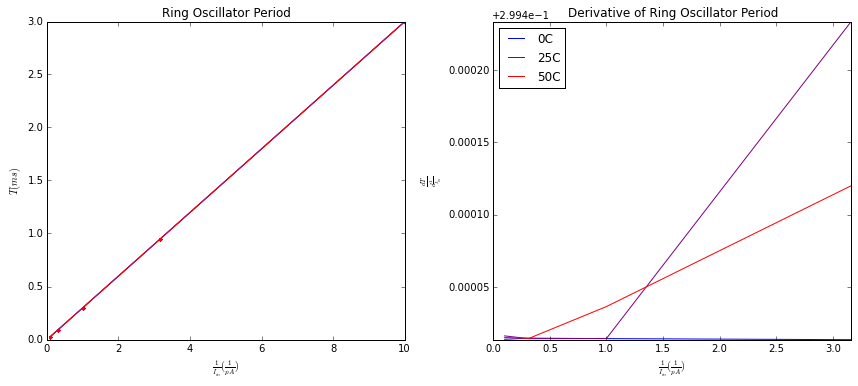

In [97]:
allTs = list(list())
globalLims = [0,0]
derivLims = [0,100000,0]

for curTemp in LessTemps:
    fileName = "AH_TempSweep_SmallIin_Systematic/AH_Inv_FreqMeas_Temp"+str(curTemp)+"C_IdealCkt.csv"
    # Note: This run required changing the readFile function that plotLinearity uses from readFile2 to readFile3
    curTs, curFitParams = plotLinearitySmallIins(fileName,Lims=None)
    #curTs, curFitParams = plotLinearitySmallIins(fileName, Lims=(2,1))
    allTs.append(curTs)
    print 'Temp: {}\tRelative RMSE: {:%}\tParams: {}'.format(curTemp,
                                                             calcRRMSE(scaledSmallIins, curTs, curFitParams),
                                                             curFitParams)
legend(loc='best')
tight_layout()

# Calculate the percentage variance that results from the variation in temperature.
TsAsFuncOfIin = array(allTs).T
#print TsAsFuncOfIin

print
print '{:>5s}\t\t{:^12s}'.format("Iins", "Percent Error")
for i, curTs in enumerate(TsAsFuncOfIin):
    #print mean(curTs), max(curTs), min(curTs), std(curTs), var(curTs)
    Iins_pA = SmallIins[i]/10**-12
    rse = (max(curTs)-min(curTs))/mean(curTs)
    print '{:>6.3f} pA\t{:^12.3%}'.format(Iins_pA, rse)

#### Ideal Currrent Sources, Ideal Inverters, Non-ideal caps
This section will show the temperature variance of non-ideal caps

Temp: 0	Relative RMSE: 0.000297%	Params: [  2.01526036e-01   3.61574130e-06  -5.03585437e-05]
Temp: 25	Relative RMSE: 0.000050%	Params: [  2.01801582e-01   4.40854998e-06  -7.31302569e-05]
Temp: 50	Relative RMSE: 0.001806%	Params: [  2.02361164e-01   1.18726906e-05  -1.11212903e-04]

 Iins		Percent Error
 0.100 pA	   0.353%   
 0.316 pA	   0.394%   
 1.000 pA	   0.428%   
 3.162 pA	   0.402%   
10.000 pA	   0.414%   


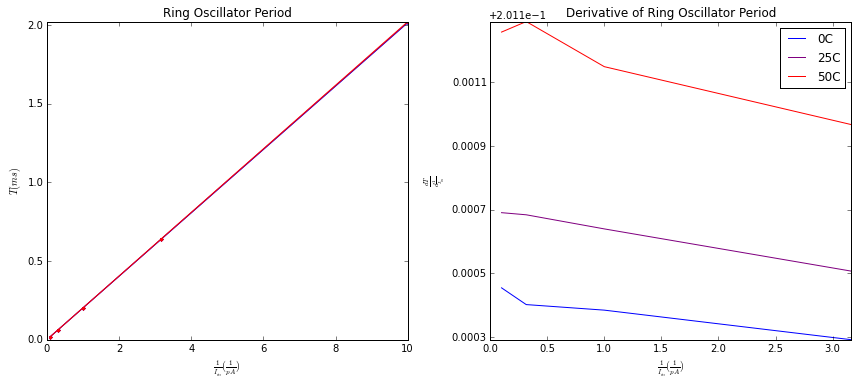

In [9]:
allTs = list(list())
globalLims = [0,0]
derivLims = [0,100000,0]

for curTemp in LessTemps:
    fileName = "AH_TempSweep_SmallIin_Systematic/AH_Inv_FreqMeas_Temp"+str(curTemp)+"C_IdealCS_IdealInv.csv"
    # Note: This run required changing the readFile function that plotLinearity uses from readFile2 to readFile3
    curTs, curFitParams = plotLinearitySmallIins(fileName,Lims=None)
    #curTs, curFitParams = plotLinearitySmallIins(fileName, Lims=(2,1))
    allTs.append(curTs)
    print 'Temp: {}\tRelative RMSE: {:%}\tParams: {}'.format(curTemp,
                                                             calcRRMSE(scaledSmallIins, curTs, curFitParams),
                                                             curFitParams)
legend(loc='best')
tight_layout()

# Calculate the percentage variance that results from the variation in temperature.
TsAsFuncOfIin = array(allTs).T
#print TsAsFuncOfIin

print
print '{:>5s}\t\t{:^12s}'.format("Iins", "Percent Error")
for i, curTs in enumerate(TsAsFuncOfIin):
    #print mean(curTs), max(curTs), min(curTs), std(curTs), var(curTs)
    Iins_pA = SmallIins[i]/10**-12
    rse = (max(curTs)-min(curTs))/mean(curTs)
    print '{:>6.3f} pA\t{:^12.3%}'.format(Iins_pA, rse)

As can be seen above, adding the non-ideal caps makes the circuit more dependent on temperature, but only marginally so.  The overall difference between measurements from 0$^\circ$C to 50$^\circ$C is less than 0.5%

#### Ideal Currrent Sources, Non-ideal Inverters, Non-ideal caps
This section will show the temperature variance of non-ideal caps and non-ideal inverters

Temp: 0	Relative RMSE: 0.005698%	Params: [ 0.17506302  0.0004464  -0.00023513]
Temp: 25	Relative RMSE: 0.004857%	Params: [  1.71841904e-01   2.62611778e-04  -6.61374540e-05]
Temp: 50	Relative RMSE: 0.009700%	Params: [  1.68219654e-01   2.54924773e-04   1.66934562e-04]

 Iins		Percent Error
 0.100 pA	   3.595%   
 0.316 pA	   3.897%   
 1.000 pA	   4.005%   
 3.162 pA	   4.345%   
10.000 pA	   5.163%   


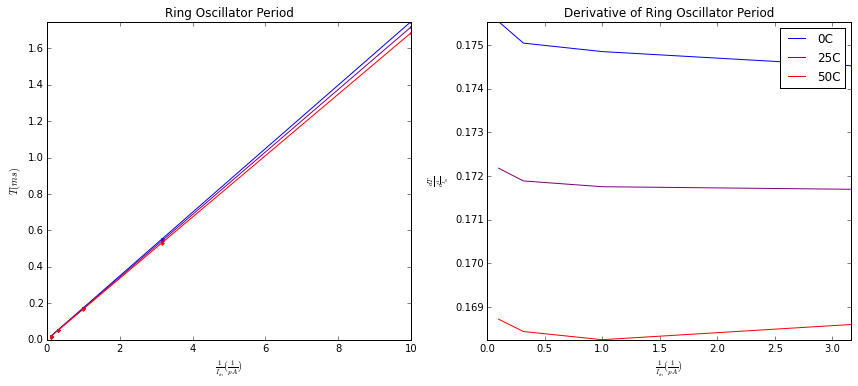

In [10]:
allTs = list(list())
globalLims = [0,0]
derivLims = [0,100000,0]

for curTemp in LessTemps:
    fileName = "AH_TempSweep_SmallIin_Systematic/AH_Inv_FreqMeas_Temp"+str(curTemp)+"C_IdealCS.csv"
    # Note: This run required changing the readFile function that plotLinearity uses from readFile2 to readFile3
    curTs, curFitParams = plotLinearitySmallIins(fileName,Lims=None)
    #curTs, curFitParams = plotLinearitySmallIins(fileName, Lims=(2,1))
    allTs.append(curTs)
    print 'Temp: {}\tRelative RMSE: {:%}\tParams: {}'.format(curTemp,
                                                             calcRRMSE(scaledSmallIins, curTs, curFitParams),
                                                             curFitParams)
legend(loc='best')
tight_layout()

# Calculate the percentage variance that results from the variation in temperature.
TsAsFuncOfIin = array(allTs).T
#print TsAsFuncOfIin

print
print '{:>5s}\t\t{:^12s}'.format("Iins", "Percent Error")
for i, curTs in enumerate(TsAsFuncOfIin):
    #print mean(curTs), max(curTs), min(curTs), std(curTs), var(curTs)
    Iins_pA = SmallIins[i]/10**-12
    rse = (max(curTs)-min(curTs))/mean(curTs)
    print '{:>6.3f} pA\t{:^12.3%}'.format(Iins_pA, rse)

Interestingly, the error for the whole chip varies greatly in this configuration, regardless of the input current's value.  The circuit, with non-ideal inverters, still has good linearity, but varies with temperature by up to 5% across all current values.  

#### Back to non-ideal elements for everything
This analysis below should be the exact same results as the baseline.

Temp: 0	Relative RMSE: 0.051782%	Params: [ 0.24823315  0.00183084 -0.00182265]
Temp: 25	Relative RMSE: 0.048869%	Params: [ 0.24833399  0.00155131 -0.00274671]
Temp: 50	Relative RMSE: 0.019616%	Params: [ 0.24992948  0.00095281 -0.00983927]

 Iins		Percent Error
 0.100 pA	   6.870%   
 0.316 pA	   1.886%   
 1.000 pA	   0.696%   
 3.162 pA	   0.695%   
10.000 pA	   1.339%   


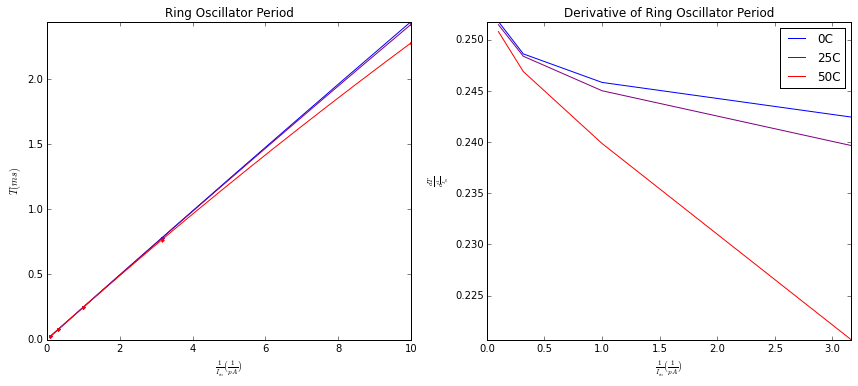

In [12]:
allTs = list(list())
globalLims = [0,0]
derivLims = [0,100000,0]

for curTemp in LessTemps:
    fileName = "AH_TempSweep_SmallIin_Systematic/AH_Inv_FreqMeas_Temp"+str(curTemp)+"C_NonIdeal.csv"
    # Note: This run required changing the readFile function that plotLinearity uses from readFile2 to readFile3
    curTs, curFitParams = plotLinearitySmallIins(fileName,Lims=None)
    #curTs, curFitParams = plotLinearitySmallIins(fileName, Lims=(2,1))
    allTs.append(curTs)
    print 'Temp: {}\tRelative RMSE: {:%}\tParams: {}'.format(curTemp,
                                                             calcRRMSE(scaledSmallIins, curTs, curFitParams),
                                                             curFitParams)
legend(loc='best')
tight_layout()

TsAsFuncOfIin = array(allTs).T
#print TsAsFuncOfIin
percVariancebyTemp(TsAsFuncOfIin, SmallIins)

The results above aren't exactly the same as before, and I think this might have to do with the fact that I have since added a $C_{min}$ argument and changed the convergence method of the simulation.  The $C_{min}$ arg changes the minimum capacitance of the wires in the circuit.  Previously, it was set to 0F, but for these past few simulations, I had it set to 1e-21F.  This shouldn't change the result by much, but should change it somewhat.

#### Temperature dependence of the delayed inverter
In talking to John to explain some of these previous results, I found out that there is a temperature dependence in the delayed inverter.  These are the same as the transistor switches used to switch off the current sources.  When we connect the source nodes of the current sources to the output of this inverter, we cause two currents to be used to charge the capacitor.  One of these currents is always equal to $I_{in}$ while the other is a decaying exponential times $I_{in}$, where the decaying exponential's time constant is dependent on the temperature.  As such, this shows that temperature will change how quickly the capacitor charges or discharges, thereby changing the period of the oscillator.

In my Mathematica model of this problem, we find that this contributes very little to the error.

#### Thick Oxide Inverter's delay varying with temperature
After we found that the delayed inverter's change in current over temperature only explains a minor portion of the error, Kwabena suggested that we look at the delay of the thick oxide inverter over temperature.  If for some reason the delay of this inverter changes with temperature, that would explain some of the variance in the system.  At that point, the next thing to check is how much of the variance it explains.

For the ease of making a measurement, we are not measuring just the delay of the first thickFET inverter, but also the delay of the second thinFET inverter.  In other words, we are measuring the overall delay of both I1 and I2, to see how long it takes for a change in $V_{cap}$ to propagate to $V_{out}$.

In [13]:
InvDelay_FileName = "AH_TempSweep_InverterDelay/InverterDelayMeas.csv"
print folderRoot+InvDelay_FileName

invDelays = genfromtxt(folderRoot+InvDelay_FileName, delimiter=',',skip_header=1)[:,1::2].T
#print invDelays

/home/noza/work/Braindrop/CDB/BDTests/AHOsc_test/Measurements/AH_TempSweep_InverterDelay/InverterDelayMeas.csv


In [14]:
avgInvDelays = mean(invDelays, axis=1)
print avgInvDelays
avgLoopDelay = avgInvDelays[::2]+avgInvDelays[1::2]
print avgLoopDelay

[  5.34313889e-08   5.94769444e-08   2.39341667e-08   2.27725000e-08
   1.07372222e-08   1.12980556e-08]
[  1.12908333e-07   4.67066667e-08   2.20352778e-08]


Now that we have the average delay of the inverter/buffer feedback stage, we can calculate what percentage of the overall delay this accounts for.

In [46]:
#print TsAsFuncOfIin
percPeriodbyDelay(TsAsFuncOfIin, SmallIins, avgLoopDelay, LessTemps)

<type 'numpy.string_'>
Percent of overall period taken by delay from feedback buffer delay
 Iins		0	25	50
  100 fA	0.005%	0.002%	0.001%
  316 fA	0.014%	0.006%	0.003%
 1000 fA	0.045%	0.019%	0.009%
 3162 fA	0.140%	0.058%	0.028%
10000 fA	0.434%	0.181%	0.086%
